#  Statistical report of LIVACID project

## Differential analysis of RNA-seq count data from seabass (*D. labrax*) samples.

The dataset is composed of 14 samples from 2 conditions : control (pH=8) and acidity (pH=7.6) and 2 sampling times (J1 and J2).
The analysis was done using [R](https://www.r-project.org/) language, [DESeq2 package](https://bioconductor.org/packages/release/bioc/html/DESeq2.html) and [SARTools](https://github.com/PF2-pasteur-fr/SARTools).

Author: SeBiMER (Pauline Auffret)

Date: 2022-02-11

## Introduction
The aim of this analysis is to find differentially expressed features between the *group* factor : *acidity* versus *control* samples. The process includes data normalization, graphical exploration of data, test for differential expression with p-value adjustment. More data exploration will include statistical testing for *sampling-day* effect and interaction of *group* and *sampling_day* factors.  
  
**3 different filters on raw counts table have been tested**  :
  - **filter A** : removes all genes where sum of expression value accross samples are inferior to 10 ;
  - **filter B** : removes all genes where the value of raw count is at least 10 in at least 50% of samples (here, 7 samples) ;
  - **filter C** : removes samples with a total raw reads inferior to 20,000,000 (here, sample 105).  
  
  
**3 statistical designs were tested were tested on filtered data** :
  - **design 1** : *counts ~ group* tests the effect of *condition* (acidity versus control) ; 
  - **design 2** : *counts ~ sampling_day + group* tests the effect of *group* (acidity versus control) and the effect of *sampling_day* (J1 versus J2) ; 
  - **design 3** : *counts ~ sampling_day + group + sampling_day:group* tests the effect of *group* (acidity versus control) and the effect of *sampling_day* (J1 versus J2) and the interaction of the 2 factors.
  - **design 4** : *counts ~ sampling_day* tests the effect of sampling_day (J1 versus J2) 
  
**This report presents the results obtained using design 2 with filter B**.

## Computing environment settings


### Packages settings
The following tools packages were used to undertake the analysis.

In [2]:
#if (!require("BiocManager", quietly = TRUE))
#  install.packages("BiocManager")
#BiocManager::install("DESeq2")
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("apeglm")
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("topGO")

In [3]:
#install.packages("gplots")
#install.packages("rlang", force=TRUE)
#install.packages("dplyr")
#install.packages("VennDiagram")

In [1]:
options(warn=-1) #deactivate this line if you need to see warnings
library(DESeq2, verbose=FALSE, quietly=TRUE)
library(ggplot2, verbose=FALSE, quietly=TRUE)
library(pheatmap, verbose=FALSE, quietly=TRUE)
library(gridExtra, verbose=FALSE, quietly=TRUE)
library(grid, verbose=FALSE, quietly=TRUE)
library(rafalib, verbose=FALSE, quietly=TRUE)
library(RColorBrewer, verbose=FALSE, quietly=TRUE)
library(gplots, verbose=FALSE, quietly=TRUE)
library(apeglm, verbose=FALSE, quietly=TRUE)
library(scales, verbose=FALSE, quietly=TRUE)
library(VennDiagram, verbose=FALSE, quietly=TRUE)
#library(topGO, verbose=FALSE, quietly=TRUE)


Attachement du package : 'BiocGenerics'


Les objets suivants sont masqués depuis 'package:stats':

    IQR, mad, sd, var, xtabs


Les objets suivants sont masqués depuis 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attachement du package : 'S4Vectors'


Les objets suivants sont masqués depuis 'package:base':

    expand.grid, I, unname



Attachement du package : 'IRanges'


L'objet suivant est masqué depuis 'package:grDevices':

    windows



Attachement du package : 'MatrixGenerics'


Les objets suivants sont masqués depuis 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCou

### Input data settings
Paths to input data include :
- **working directory** where the output are saved
- **STAR output directory** (STAR mapper produces raw matrix of features counts for each samples)
- **target file** which describes the samples and their attributes
- **functions** file containing usefull R functions to plot results
- **annotation files** containing functionnal annotations about genes (the GOs file comes from the previous analysis carried out on seabass RNA-seq data)

In [2]:
working_dir <- "OUTPUT/DEG"
star <- "OUTPUT/star"
target <- "DATA/target_col4.txt"
function_file <- "SRC/R/functions.r"
go_file <- "DATA/dicLab1_scaffold.gene2go"
ann_file <- "DATA/dicLab1_scaffold.b2g"

### Input parameters
The parameters include :
- **lines to remove from count matrix** for the analysis (here the lines to remove are summary lines)
- **filter threshold for minimun expression**
- **minimum number of reads for a given sample**
- **experimental design to test**

In [3]:
featuresToRemove <- c("N_unmapped","N_multimapping","N_noFeature","N_ambiguous")
threshold <- 10 #min expression value accross samples
minNumberOfReads <- 20000000

design1 <- counts ~ group
design2 <- counts ~ sampling_day + group 
design3 <- counts ~ sampling_day + group + sampling_day:group
design4 <- counts ~ sampling_day

In [4]:
design <- design2
filter <- "filterb"


### Data loading

In [6]:
# Change working directory
setwd(working_dir)  
# Source R function file
source(function_file)
# Load input data
curdir <- star        
sampleSheet <- target
samplesInfo <- read.table(sampleSheet, h=T) 
target_file <- samplesInfo[,c(1,2,3,4)]

## Design 2 - filter B

In [7]:
target_file$group <- factor(target_file$group, levels=c("control","acidity"))
target_file$sampling_day <- factor(target_file$sampling_day, levels=c("J1","J2"))
design <- formula(design)

### Data exploration

#### Input datatable

In [8]:
target_file
print(paste("The input datatable is composed of ",dim(target_file)[1]," lines and ", dim(target_file)[2], " columns", sep=""))

label  files                                              group  
1  id_102 102_S7_R1_001_trimmedReadsPerGene.out.tab_4deseq2  control
2  id_103 103_S8_R1_001_trimmedReadsPerGene.out.tab_4deseq2  control
3  id_105 105_S9_R1_001_trimmedReadsPerGene.out.tab_4deseq2  control
4  id_121 121_S10_R1_001_trimmedReadsPerGene.out.tab_4deseq2 acidity
5  id_125 125_S11_R1_001_trimmedReadsPerGene.out.tab_4deseq2 acidity
6  id_126 126_S12_R1_001_trimmedReadsPerGene.out.tab_4deseq2 acidity
7  id_128 128_S13_R1_001_trimmedReadsPerGene.out.tab_4deseq2 acidity
8  id_129 129_S14_R1_001_trimmedReadsPerGene.out.tab_4deseq2 acidity
9  id_73  73_S1_R1_001_trimmedReadsPerGene.out.tab_4deseq2   control
10 id_75  75_S2_R1_001_trimmedReadsPerGene.out.tab_4deseq2   control
11 id_76  76_S3_R1_001_trimmedReadsPerGene.out.tab_4deseq2   control
12 id_79  79_S4_R1_001_trimmedReadsPerGene.out.tab_4deseq2   control
13 id_97  97_S5_R1_001_trimmedReadsPerGene.out.tab_4deseq2   acidity
14 id_98  98_S6_R1_001_trimmedReadsPerGene.out.tab_4deseq2   acidity
   sampling_day
1  J2          
2  J2          
3  J2          
4  J2          
5  J2          
6  J2          
7  J2          
8  J2          
9  J1          
10 J1          
11 J1          
12 J1          
13 J1          
14 J1

[1] "The input datatable is composed of 14 lines and 4 columns"


### DESeq object 

In [9]:
#Import count data 
if (design == design1) {
    ddsHTSeq <- DESeqDataSetFromHTSeqCount(sampleTable = target_file, directory = star, design=~group)
} else if (design == design2) {
    ddsHTSeq <- DESeqDataSetFromHTSeqCount(sampleTable = target_file, directory = star, design=~sampling_day+group)
} else if (design == design3) {
    ddsHTSeq <- DESeqDataSetFromHTSeqCount(sampleTable = target_file, directory = star, design=~sampling_day+group)+group:sampling_day
}
#Trims unwanted features
wanted <- setdiff(rownames(ddsHTSeq), featuresToRemove)
ddsHTSeq <- ddsHTSeq[wanted,] 

#Trims too low transcripts
if (filter == "filtera") {
    ddsHTSeq <- ddsHTSeq[ rowSums(counts(ddsHTSeq)) > threshold, ]
} else if (filter == "filterb") {
    ddsHTSeq <- ddsHTSeq[ rowSums(counts(ddsHTSeq) >= threshold) >= dim(target_file)[1]/2, ]
}

#Look at resulting object
print("This is DESeq object containing count data")
ddsHTSeq


[1] "This is DESeq object containing count data"


class: DESeqDataSet 
dim: 16816 14 
metadata(1): version
assays(1): counts
rownames(16816): DLAgn_00000030 DLAgn_00000060 ... DLAgn_00267170
  DLAgn_00267190
rowData names(0):
colnames(14): id_102 id_103 ... id_97 id_98
colData names(2): group sampling_day

### Count data exploration
After loading the data we first have a look at the raw data table itself. The data table contains one row per annotated feature and one column per sequenced sample. Row names of this table are feature IDs (unique identifiers). The table contains raw count values representing the number of reads that map onto the features.  

Looking at the summary of the count table provides a basic description of these raw counts (min and max values, median, etc).

id_102 id_103 id_105 id_121 id_125 id_126 id_128 id_129 id_73
DLAgn_00000030   13     23     9      24     6      34    14       8    17  
DLAgn_00000060   23     23     4       6    10      13    11       8    13  
DLAgn_00000090 2618   1166   233    1027   723     997   605    1686   817  
DLAgn_00000110  754    655   161     710   499    1007   521     593   843  
DLAgn_00000120  297    232   109     287   204     350   274     211   292  
DLAgn_00000160  603    672   173     540   373     635   473     394   701  
               id_75 id_76 id_79 id_97 id_98
DLAgn_00000030   15    36   15    25     32 
DLAgn_00000060   37    21    6     2     31 
DLAgn_00000090 1331  2171  738   858   1769 
DLAgn_00000110  830  1154  643   531   1116 
DLAgn_00000120  338   425  307   182    440 
DLAgn_00000160  736  1073  490   455    819

     id_102            id_103            id_105           id_121       
 Min.   :      0   Min.   :      0   Min.   :     0   Min.   :      0  
 1st Qu.:     95   1st Qu.:     96   1st Qu.:    23   1st Qu.:     75  
 Median :    392   Median :    368   Median :   107   Median :    333  
 Mean   :   3069   Mean   :   2946   Mean   :   975   Mean   :   2748  
 3rd Qu.:   1189   3rd Qu.:   1086   3rd Qu.:   341   3rd Qu.:   1015  
 Max.   :2421803   Max.   :2190531   Max.   :792793   Max.   :2781928  
     id_125            id_126            id_128            id_129       
 Min.   :      0   Min.   :      0   Min.   :      0   Min.   :      0  
 1st Qu.:     62   1st Qu.:    104   1st Qu.:     66   1st Qu.:     66  
 Median :    270   Median :    434   Median :    295   Median :    276  
 Mean   :   2247   Mean   :   3598   Mean   :   2259   Mean   :   2280  
 3rd Qu.:    843   3rd Qu.:   1322   3rd Qu.:    923   3rd Qu.:    862  
 Max.   :2096357   Max.   :3177632   Max.   :1818599   Max

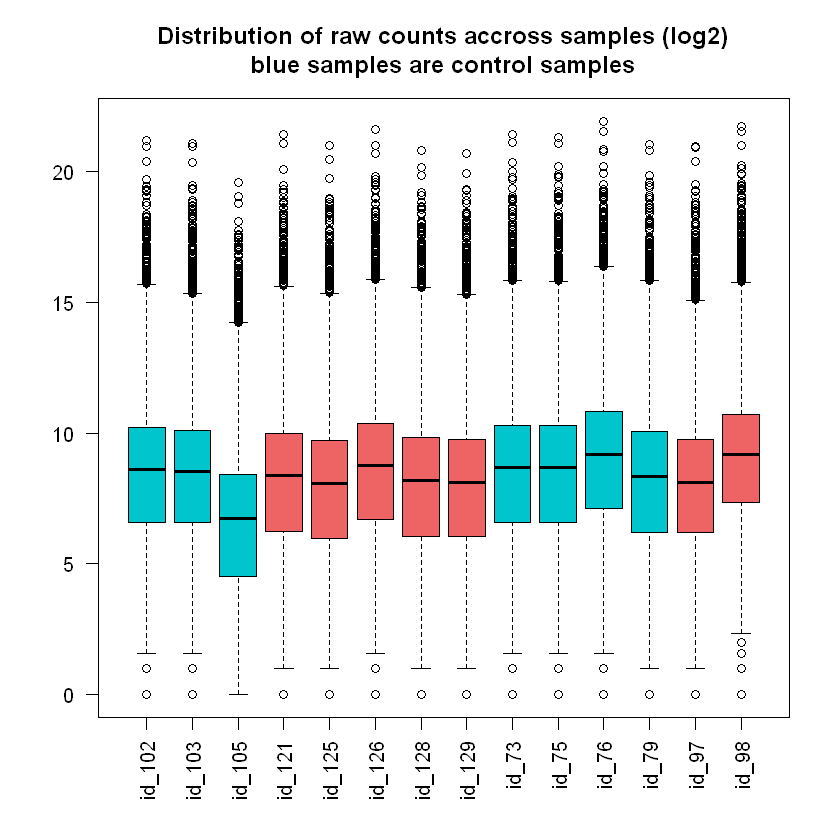

In [10]:
# Explore count data
sample_list <- target_file$group
sample_color <- ifelse(sample_list=="control","turquoise3","indianred2")
head(counts(ddsHTSeq))
summary(counts(ddsHTSeq))
boxplot(log(counts(ddsHTSeq),2), col=sample_color, las=2, main="Distribution of raw counts accross samples (log2)\nblue samples are control samples", warning=F)


#### Total number of counts accross samples

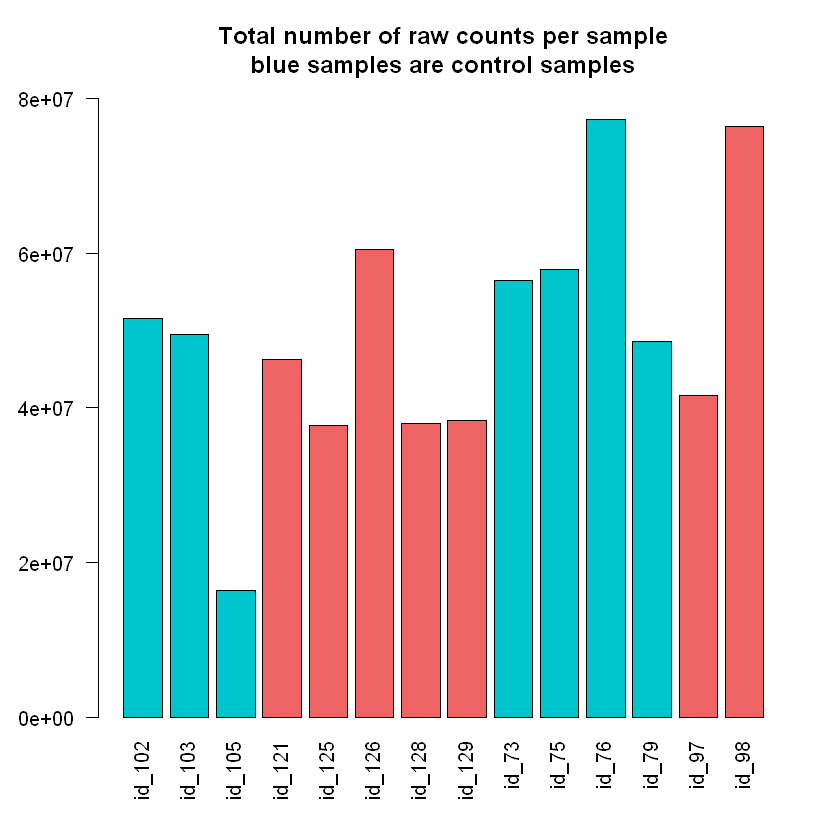

In [11]:
barplot(colSums(counts(ddsHTSeq)), col=sample_color, las=2, ylim=c(0,80000000), main="Total number of raw counts per sample\nblue samples are control samples")


#### Number of low expressed transcripts (<5 read counts)

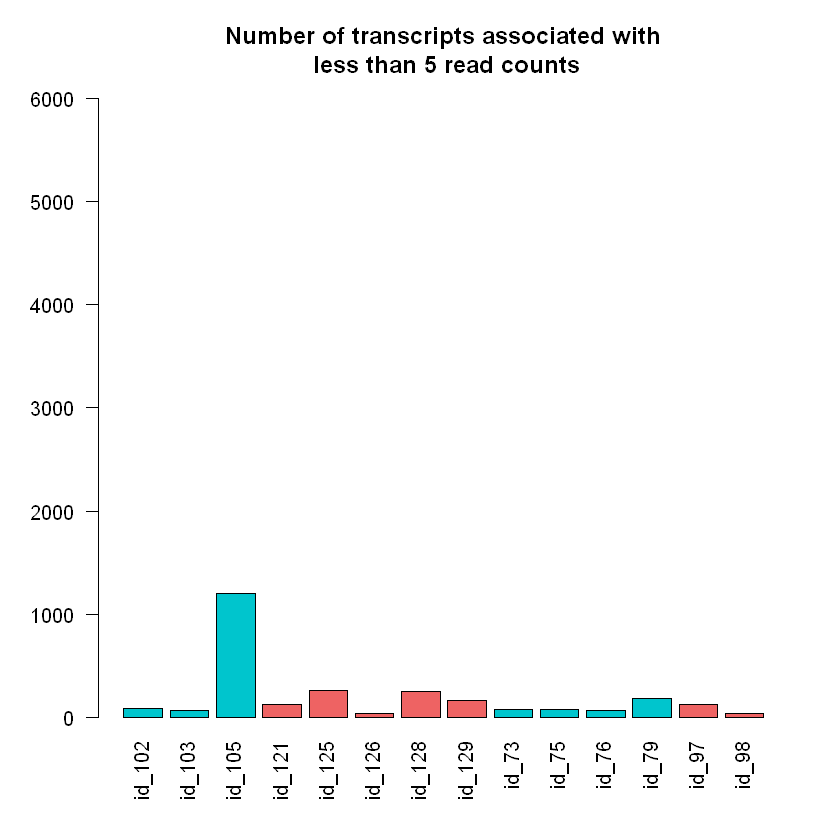

In [12]:
barplot(colSums(counts(ddsHTSeq)<5), col=sample_color, las=2, ylim=c(0,6000), main="Number of transcripts associated with\n less than 5 read counts")


#### Density of counts distribution

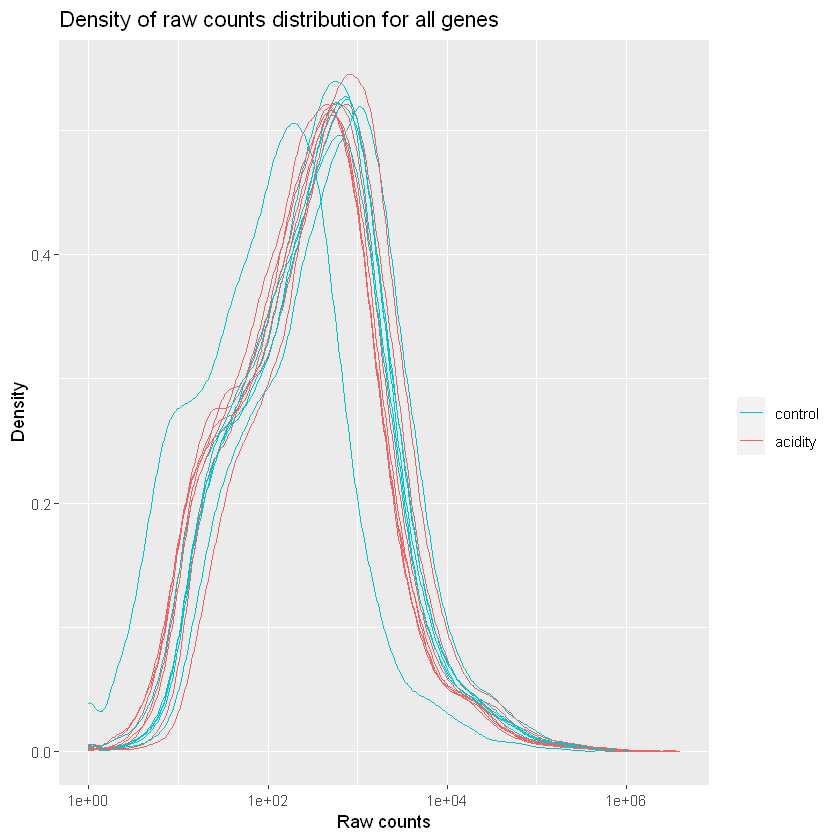

In [13]:
# Get counts to plot counts distribution for each sample
ct <- counts(ddsHTSeq)
d <- stack(data.frame(ct))
group <- target_file$group
d$group <- rep(group, each=nrow(ct))
dp_raw_all <- ggplot(d, aes(x=.data$values+1)) +
    stat_density(aes(group=.data$ind, color=.data$group), position="identity", geom="line", show.legend=TRUE) +
    scale_colour_manual(values=c("turquoise3","indianred2")) +
    scale_x_continuous(trans = log10_trans(),
                               breaks = trans_breaks("log10", function(x) 10^x))+#,
                               #labels = trans_format("log10", math_format(~10^.x))) +
    labs(color="") +
    #scale_colour_manual(values=d$color) +
    xlab("Raw counts") +
    ylab("Density") +
    ggtitle("Density of raw counts distribution for all genes") +
    theme_gray()
dp_raw_all

### Model fitting
DESeq2 aims at fitting one linear model per feature. 
For this project, the design used is *counts ~ group* and the goal is to estimate the models' coefficients which can be interpreted as log2(FC). These coefficients will then be tested to get p-values and adjusted p-values.

In [14]:
#DEseq object
ddsp <- DESeq(ddsHTSeq, fitType="parametric")
dds <- DESeq(ddsHTSeq, fitType="local")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



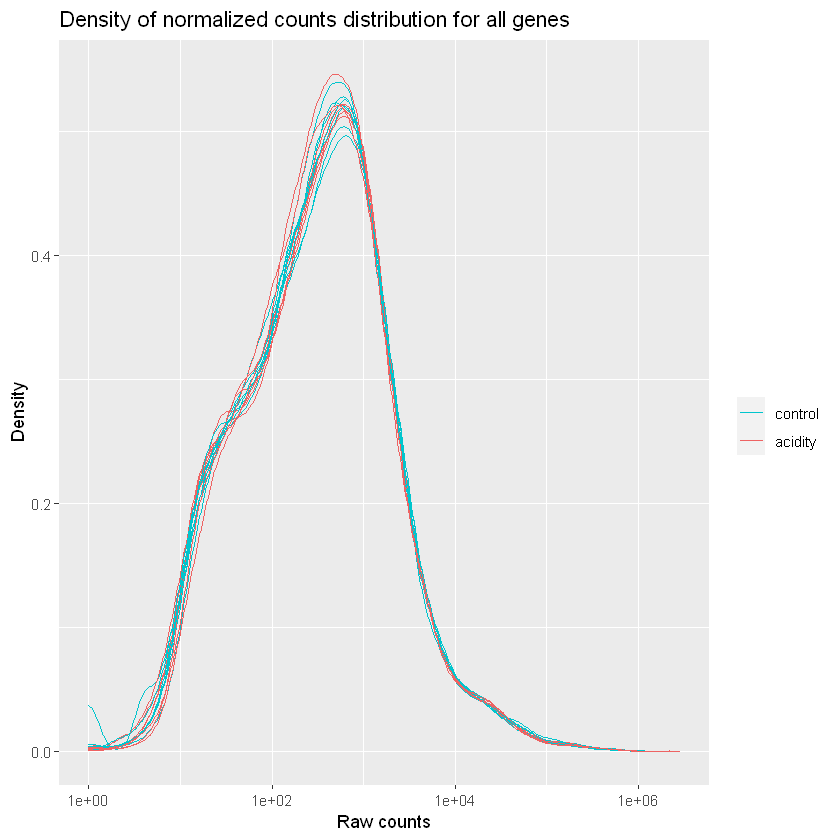

In [15]:
# Get counts to plot counts distribution for each sample
ct <- counts(dds, normalized=TRUE)
d <- stack(data.frame(ct))
group <- target_file$group
d$group <- rep(group, each=nrow(ct))
dp_norm_all <- ggplot(d, aes(x=.data$values+1)) +
    stat_density(aes(group=.data$ind, color=.data$group), position="identity", geom="line", show.legend=TRUE) +
    scale_x_continuous(trans = log10_trans(),
                               breaks = trans_breaks("log10", function(x) 10^x))+#,labels = trans_format("log10", math_format(~10^.x))) +
    labs(color="") +
    scale_colour_manual(values=c("turquoise3","indianred2")) +
    xlab("Raw counts") +
    ylab("Density") +
    ggtitle("Density of normalized counts distribution for all genes") +
    theme_gray()
dp_norm_all

## Graphical exploration

The main variability within the experiment is expected to come from biological differences between the samples. This can be checked in two ways. The first one is to perform a hierarchical clustering of the whole sample set. This is performed after a transformation of the count data which can be either a Variance Stabilizing Transformation (VST) or a regularized log transformation (rlog).  

A VST is a transformation of the data that makes them homoscedastic, meaning that the variance is then independent of the mean. It is performed in two steps: (i) a mean-variance relationship is estimated from the data with the same function that is used to normalize count data and (ii) from this relationship, a transformation of the data is performed in order to get a dataset in which the variance is independent of the mean. The homoscedasticity is a prerequisite for the use of some data analysis methods, such as hierarchical clustering or Principal Component Analysis (PCA). The regularized log transformation is based on a GLM (Generalized Linear Model) on the counts and has the same goal as a VST but is more robust in the case when the size factors vary widely.


### Principal component analysis

Principal ocmponent analysis is computed to look at experiment variability. When plotted, the first principal component (PC1) is expected to separate samples from the different biological conditions, meaning that the biological variability is the main source of variance in the data.


PC1         PC2          group      group.1 sampling_day name  
id_102  -1.6768668  -4.98930014 control:J2 control J2           id_102
id_103   1.6715511   8.23996846 control:J2 control J2           id_103
id_105  -6.2330273 -11.41609232 control:J2 control J2           id_105
id_121  11.9662403  -4.21869495 acidity:J2 acidity J2           id_121
id_125   9.4630692 -10.22168521 acidity:J2 acidity J2           id_125
id_126   8.4314622   4.66050141 acidity:J2 acidity J2           id_126
id_128   3.5813049  -6.22878240 acidity:J2 acidity J2           id_128
id_129   2.8708950   3.75281674 acidity:J2 acidity J2           id_129
id_73   -1.9949392   4.81141648 control:J1 control J1           id_73 
id_75   -7.4490879  -0.02381898 control:J1 control J1           id_75 
id_76  -14.0428767   5.86079624 control:J1 control J1           id_76 
id_79  -17.9324948  -4.31202345 control:J1 control J1           id_79 
id_97   11.5957740   3.72131581 acidity:J1 acidity J1           id_97 
id_98   -0.2510039  10.36358232 acidity:J1 acidity J1           id_98

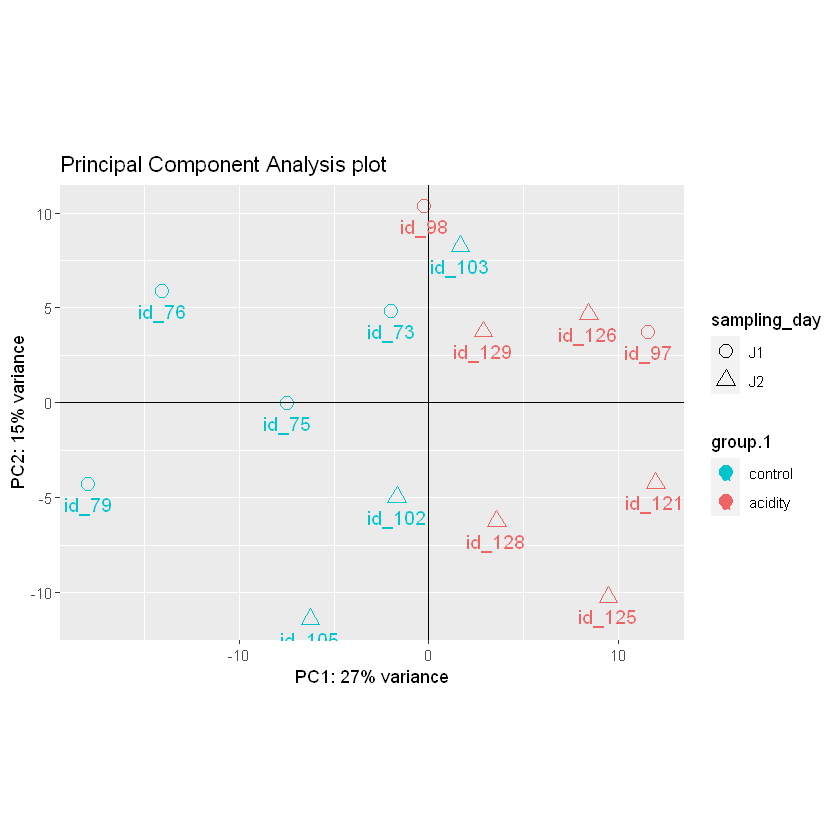

In [16]:
rld <- rlog(ddsHTSeq, blind=FALSE)
data <- plotPCA(rld, intgroup=c("group","sampling_day"), returnData=TRUE)#, ntop=100000)
data
percentVar <- round(100*attr(data, "percentVar"))
pca1 <- ggplot(data, aes(PC1, PC2, color=group.1, shape=sampling_day)) +
  geom_point(size=3.5) +#, fill="black", stroke=0.8) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  coord_fixed() + ggtitle("Principal Component Analysis plot") +
  geom_hline(aes(yintercept=0)) +
  geom_vline(aes(xintercept=0)) +
  scale_shape_manual(values=c(21,24)) +
  scale_color_manual(values=c("turquoise3","indianred2")) +
  geom_text(aes(label=colnames(ddsHTSeq)),hjust=0.5, vjust=1.8, size=4)
pca1


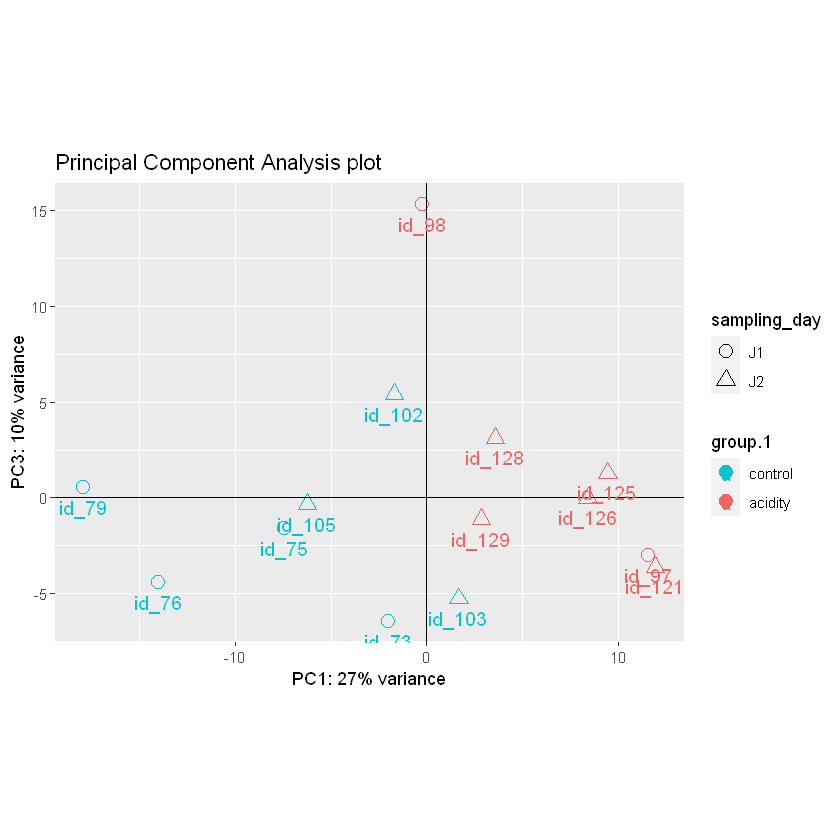

In [19]:
data <- plotPCA.san(rld, intgroup=c("group","sampling_day"), returnData=TRUE)#, ntop=100000)
percentVar <- round(100*attr(data, "percentVar"))
pca2 <- ggplot(data, aes(PC1, PC3, color=group.1, shape=sampling_day)) +
  geom_point(size=3.5) +#, fill="black", stroke=0.8) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC3: ",percentVar[3],"% variance")) +
  coord_fixed() + ggtitle("Principal Component Analysis plot") +
  geom_hline(aes(yintercept=0)) +
  geom_vline(aes(xintercept=0)) +
  scale_shape_manual(values=c(21,24)) +
  scale_color_manual(values=c("turquoise3","indianred2")) +
  geom_text(aes(label=colnames(ddsHTSeq)),hjust=0.5, vjust=1.8, size=4)
pca2

### Clustering and heatmap

Clustering is computed from rlog-transformed data. An euclidean distance is computed between samples, and the dendrogram is built upon the Ward criterion. We expect this dendrogram to group replicates and separate biological conditions.

[1] 16816    14

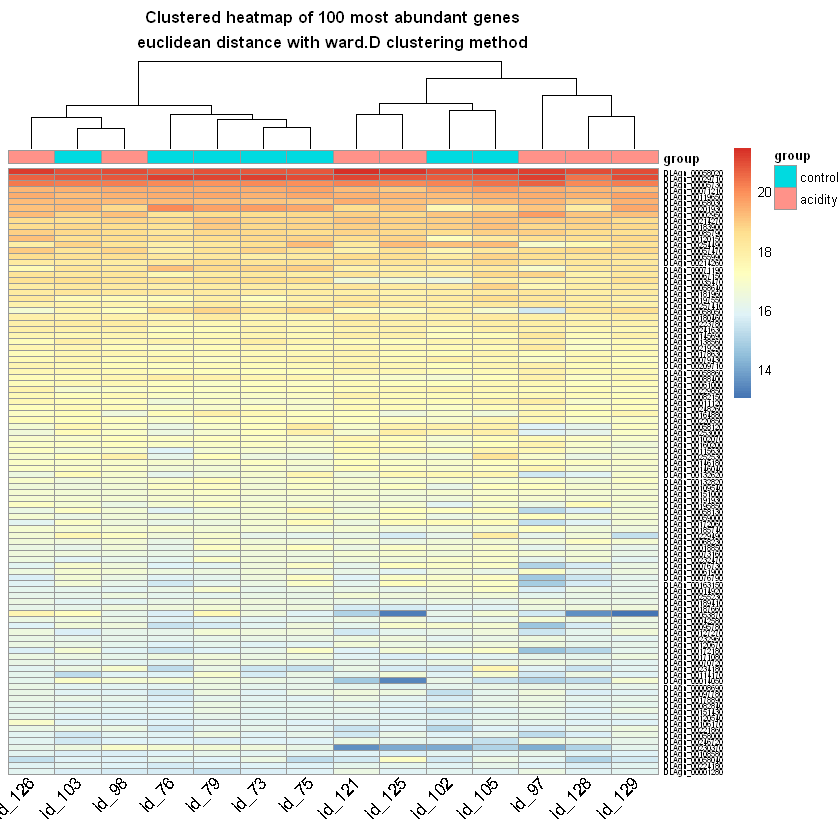

In [20]:
#Heatmap
#Selects only most abundant transcripts
nCounts <- counts(dds, normalized=TRUE)
select <- order(rowMeans(nCounts),decreasing=TRUE)[1:100]

#Selects corresponding norm counts
nt <- normTransform(dds)
log2.norm.counts <- assay(nt)[select,]
log2.norm.counts.to.export <- assay(nt)
colnames(log2.norm.counts.to.export) <- colnames(ddsHTSeq)
dim(log2.norm.counts.to.export)

#Gets the metadata
colnames(log2.norm.counts) <- colnames(ddsHTSeq)
df <- as.data.frame(colData(dds)["group"])
rownames(df) <- colnames(ddsHTSeq)

#Heatmap parameters
dist1 <- "euclidean"
clust <- "ward.D"
ann_colors = list(Color = c(Acidity = "indianred2", Control = "turquoise3"))

## 'Overwrite' default draw_colnames with your own version 
assignInNamespace(x="draw_colnames", value="draw_colnames_45",ns=asNamespace("pheatmap"))

#Draw heatmap
pheatmap(log2.norm.counts,
         clustering_distance_cols = dist1, 
         clustering_method = clust, 
         cluster_rows=FALSE,
         cluster_cols=TRUE, 
         annotation_col=df,
         show_rownames=TRUE,
         fontsize_row=5,
         fontsize_col=10,
         fontsize=8,
         annotation_colors = ann_colors, 
         main=paste("Clustered heatmap of 100 most abundant genes\n",dist1," distance with ",clust, " clustering method",sep=""),
         las=1)



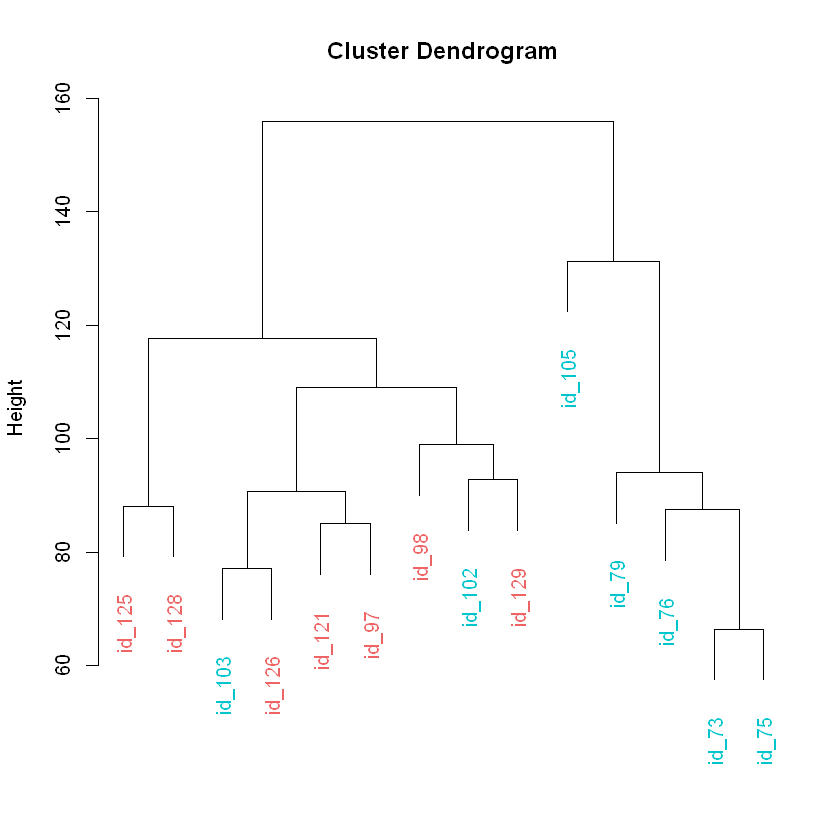

In [21]:
#Clustering
#Normalized counts
nt <- normTransform(dds)
log2.norm.counts <- assay(nt)

#Gets the metadata
colnames(log2.norm.counts) <- colnames(ddsHTSeq)
df <- as.data.frame(colData(dds)["group"])
rownames(df) <- colnames(ddsHTSeq)

#Heatmap parameters
dist1 <- "euclidean"
clust <- "ward.D"

#Build distance matrix
distance_matrix <- dist(t(log2.norm.counts), method = dist1)
hh <- hclust(distance_matrix, method = clust)
colo <- target_file[target_file$label==hh$labels,3]
colo <- ifelse(colo=="control","turquoise3","indianred2")

#plot clustering
myplclust(hh, labels=rownames(df), lab.col=colo)


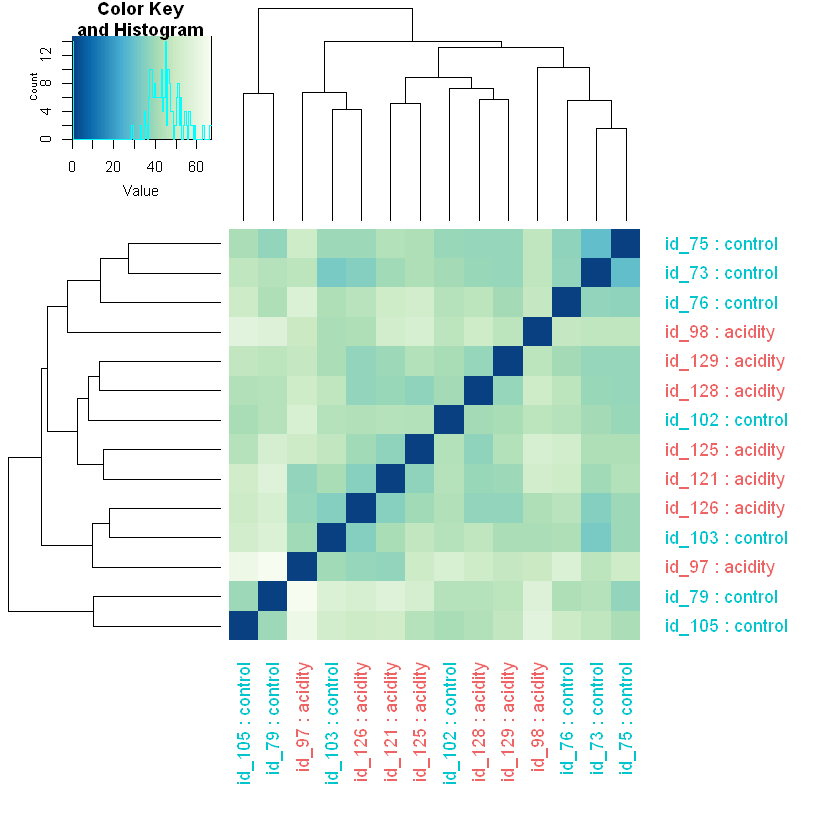

In [22]:
#Heatmap sample to sample
distsRL <- dist(t(assay(rld)))
mat<- as.matrix(distsRL)
rownames(mat) <- colnames(mat) <- with(colData(dds), paste(colnames(ddsHTSeq), group , sep=' : '))
hc <- hclust(distsRL)
hmcol <- colorRampPalette(brewer.pal(9, "GnBu"))(100)

heatmap.2(mat, Rowv=as.dendrogram(hc),
          symm=TRUE, trace='none',
          col=rev(hmcol),margin=c(10, 10), colRow=colo, colCol=colo)


## Dispersion estimation

The DESeq2 model assumes that the count data follow a negative binomial distribution which is a robust alternative to the Poisson law when data are over-dispersed (the variance is higher than the mean). The first step of the statistical procedure is to estimate the dispersion of the data. Its purpose is to determine the shape of the mean-variance relationship. The default is to apply a GLM (Generalized Linear Model) based method (fitType=“parametric”), which can handle complex designs but may not converge in some cases. The alternative is to use fitType=“local” as described in the original paper. The parameter used for this project is fitType=“parametric”. Then, DESeq2 imposes a Cox Reid-adjusted profile likelihood maximization and uses the maximum a posteriori (MAP) of the dispersion.
Dispersions estimations
Figure 11:  (left) 

On the dispersion estimation plot, the x- and y-axes represent the mean count value and the estimated dispersion respectively. Black dots represent empirical dispersion estimates for each feature (from the observed counts). The red dots show the mean-variance relationship function (fitted dispersion value) as estimated by the model. The blue dots are the final estimates from the maximum a posteriori and are used to perform the statistical test. Blue circles (if any) point out dispersion outliers. These are features with a very high empirical variance (computed from observed counts). These high dispersion values fall far from the model estimation. For these features, the statistical test is based on the empirical variance in order to be more conservative than with the MAP dispersion. These features will have low chance to be declared significant. The figure on the right panel allows to check the hypothesis of log-normality of the dispersions.

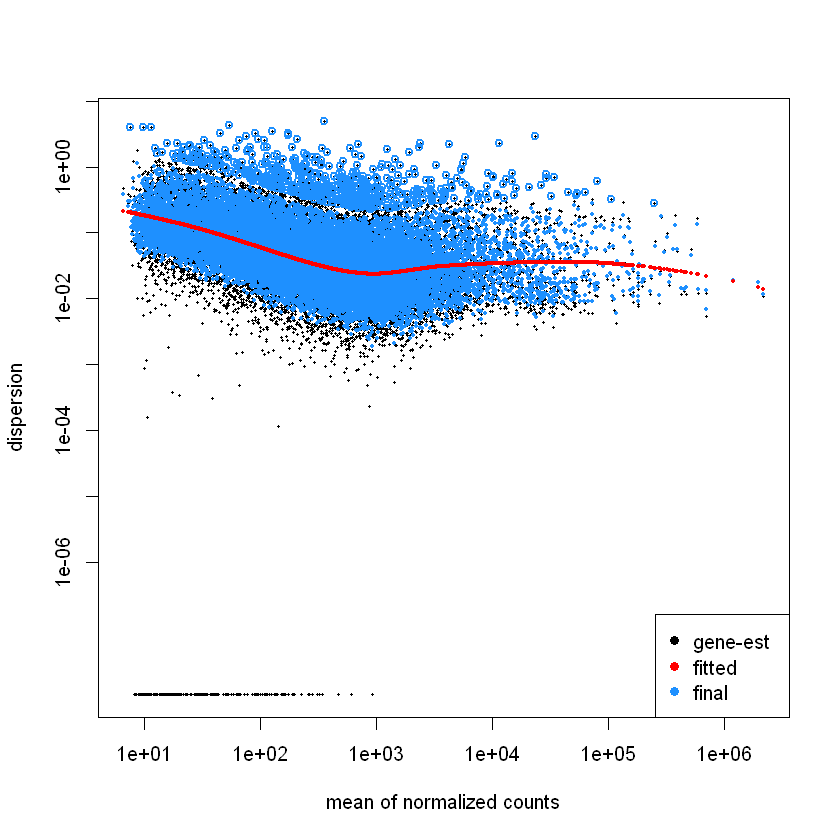

In [23]:
#Plot dispersion plot
plotDispEsts(dds)

## Statistical testing for differentially expressed genes
Once the dispersion estimation and the model fitting have been done, DESeq2 can perform the statistical testing. 
A p-value adjustment is performed to take into account multiple testing and control the false positive rate to a chosen level α. For this analysis, a BH p-value adjustment was performed and the level of controlled false positive rate was set to 0.05.

In [32]:
## DE analysis
resultsNames(dds)
# Setting contrasts
contrast <- c("group", "acidity", "control")
    # DE test with BH correction and alpha <0.05
    res_raw <- results(dds, contrast = contrast, alpha = 0.01, pAdjustMethod = "BH")
    # lfc shrinkage
    res <- lfcShrink(dds=dds, coef="group_acidity_vs_control", type="apeglm", quiet=TRUE)
if (design == "counts ~ sampling_day") {
    contrast <- c("sampling_day", "J1", "J2")
    # DE test with BH correction and alpha <0.05
    res_raw <- results(dds, contrast = contrast, alpha = 0.01, pAdjustMethod = "BH")
    # lfc shrinkage
    res <- lfcShrink(dds=dds, coef="sampling_day_J2_vs_J1", type="apeglm", quiet=TRUE)
}

[1] "Intercept"                "sampling_day_J2_vs_J1"   
[3] "group_acidity_vs_control"

### MA plots
"MA plots are commonly used to represent log fold-change versus mean expression between two treatments (Figure 4). This is visually displayed as a scatter plot with base-2 log fold-change along the y-axis and normalized mean expression along the x-axis. Data points with extreme values along the y-axis represent the genes that have highly differential expression levels (although, not necessarily differentially expressed). Typically, lower mean expression values will have more variability in log fold-change than the higher expression value. This results in a fanning effect of the data points as the graph moves from right to left. Since there are standard thresholds for log fold-changes, MA plots will many times have indications of these cutoffs. However, since this figure does not display any measure of statistical significance, it does not directly indicate which data points are statistically differentially expressed. To accommodate this, some MA plots will color data points to show which have below-threshold adjusted P-values".  

From McDermaid A, Monier B, Zhao J, Liu B, Ma Q. Interpretation of differential gene expression results of RNA-seq data: review and integration. Brief Bioinform. 2019 Nov 27;20(6):2044-2054. doi: 10.1093/bib/bby067. PMID: 30099484; PMCID: PMC6954399.

[1] 681   3
[1] 678   3


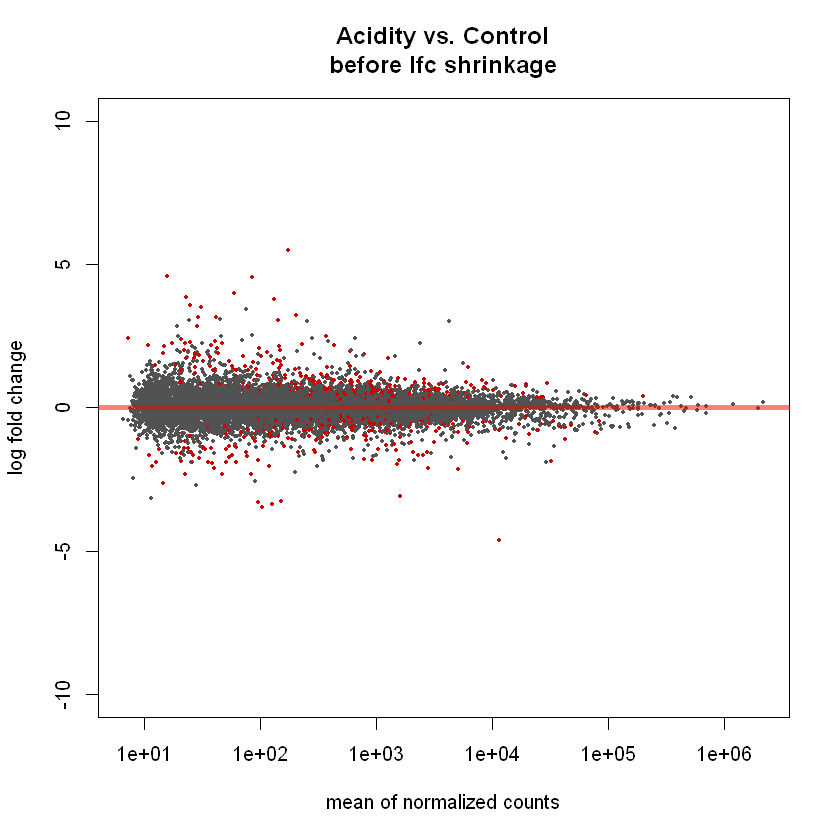

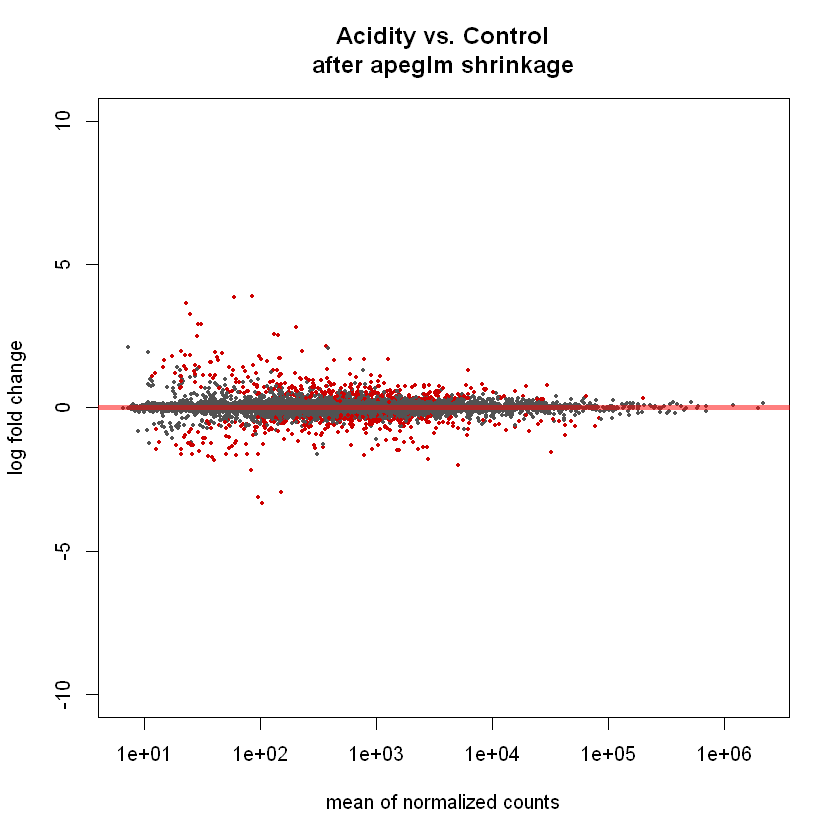

In [33]:
## MA plots 
plotMA.DESeqResults(res_raw, main="Acidity vs. Control\nbefore lfc shrinkage", ylim=c(-10,10),alpha=0.05)
plotMA.DESeqResults(res, main="Acidity vs. Control\nafter apeglm shrinkage", ylim=c(-10,10),alpha=0.05)

### Differentially expresssed genes (DEGs)

In [34]:
res <- as.data.frame(res)
res$geneName <- rownames(res)

#Selects results with p-value <= 0.01 
res0.01 <- res[which(res$padj<=0.01),] ;  #dim(res0.01)[1]
nbUp0.01 <- dim(res0.01[which(res0.01$log2FoldChange>0),])[1]
nbDown0.01 <- dim(res0.01[which(res0.01$log2FoldChange<0),])[1]

#Selects results with p-value <= 0.05 
res0.05 <-res[which(res$padj<=0.05),] ;  #dim(res0.05)[1]
nbUp0.05 <- dim(res0.05[which(res0.05$log2FoldChange>0),])[1]
nbDown0.05 <- dim(res0.05[which(res0.05$log2FoldChange<0),])[1]

#Apply a filter on log2FC (>1.5)
res0.01_1.5 <-res0.01[which(abs(res0.01$log2FoldChange) >= 1.5),] ; #dim(res0.01_1.5)[1]
nbUp0.01_1.5 <- dim(res0.01_1.5[which(res0.01_1.5$log2FoldChange>0),])[1]
nbDown0.01_1.5 <- dim(res0.01_1.5[which(res0.01_1.5$log2FoldChange<0),])[1]

res0.05_1.5 <-res0.05[which(abs(res0.05$log2FoldChange) >= 1.5),] ; #dim(res0.05_1.5)[1]
nbUp0.05_1.5 <- dim(res0.05_1.5[which(res0.05_1.5$log2FoldChange>0),])[1]
nbDown0.05_1.5 <- dim(res0.05_1.5[which(res0.05_1.5$log2FoldChange<0),])[1]

#Print number of DE genes
print(paste("Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.01) : ", dim(res0.01)[1], ", including ", nbUp0.01, " up-regulated genes and ", nbDown0.01, " down-regulated genes.", sep=""))
print(paste("Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.05) : ", dim(res0.05)[1], ", including ", nbUp0.05, " up-regulated genes and ", nbDown0.05, " down-regulated genes.", sep=""))
print(paste("Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.01 and |log2FC| > 1.5 ) : ", dim(res0.01_1.5)[1], ", including ", nbUp0.01_1.5, " up-regulated genes and ", nbDown0.01_1.5, " down-regulated genes.", sep=""))
print(paste("Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.05 and |log2FC| > 1.5 ) : ", dim(res0.05_1.5)[1], ", including ", nbUp0.05_1.5, " up-regulated genes and ", nbDown0.05_1.5, " down-regulated genes.", sep=""))

[1] "Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.01) : 236, including 125 up-regulated genes and 111 down-regulated genes."
[1] "Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.05) : 678, including 354 up-regulated genes and 324 down-regulated genes."
[1] "Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.01 and |log2FC| > 1.5 ) : 39, including 21 up-regulated genes and 18 down-regulated genes."
[1] "Number of differentially expressed genes in control versus acidity (adjusted pvalue < 0.05 and |log2FC| > 1.5 ) : 50, including 32 up-regulated genes and 18 down-regulated genes."


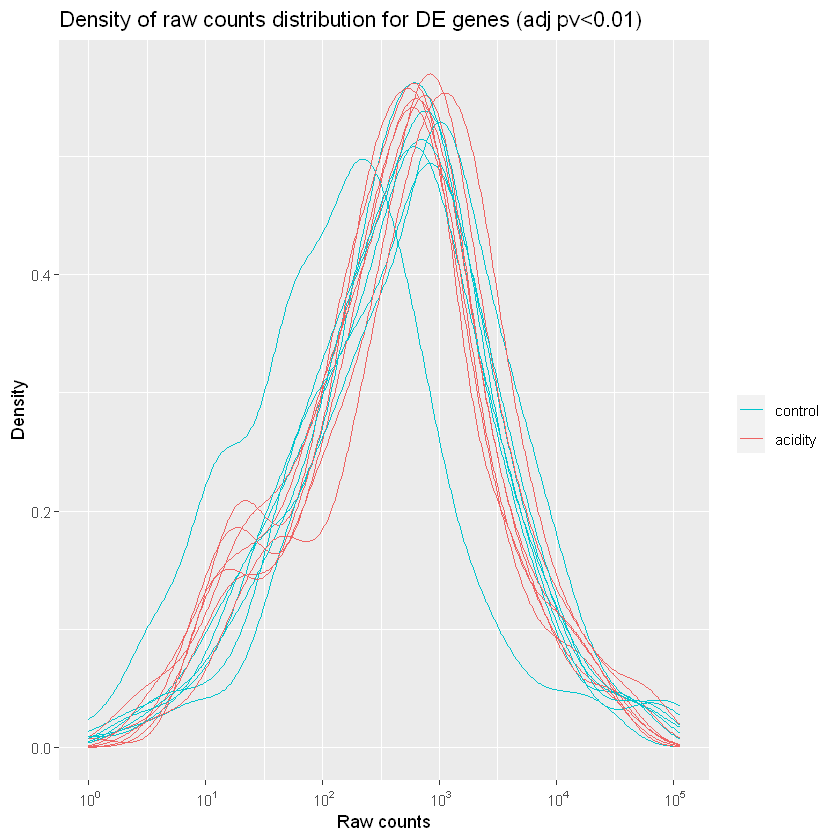

In [35]:
# Get counts to plot counts distribution for each sample
ct <- counts(ddsHTSeq[rownames(res0.01),])
d <- stack(data.frame(ct))
group <- target_file$group
d$group <- rep(group, each=nrow(ct))
dp_raw_DE0.01 <- ggplot(d, aes(x=.data$values+1)) +
    stat_density(aes(group=.data$ind, color=.data$group), position="identity", geom="line", show.legend=TRUE) +
    scale_x_continuous(trans = log10_trans(),
                               breaks = trans_breaks("log10", function(x) 10^x),
                               labels = trans_format("log10", math_format(~10^.x))) +
    labs(color="") +
    #scale_colour_manual(values=d$color) +
    xlab("Raw counts") +
    ylab("Density") +
    scale_colour_manual(values=c("turquoise3","indianred2")) +
    ggtitle("Density of raw counts distribution for DE genes (adj pv<0.01)") +
    theme_gray()
dp_raw_DE0.01

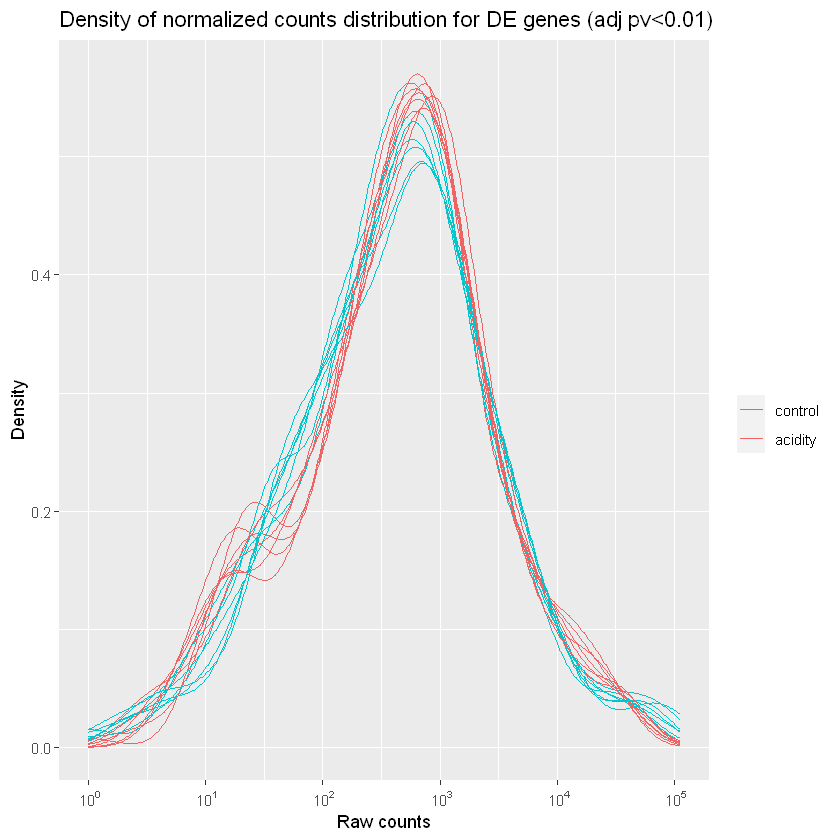

In [36]:
# Get counts to plot counts distribution for each sample
ct <- counts(dds[rownames(res0.01),], normalized=TRUE)
d <- stack(data.frame(ct))
group <- target_file$group
d$group <- rep(group, each=nrow(ct))
dp_norm_DE0.01 <- ggplot(d, aes(x=.data$values+1)) +
    stat_density(aes(group=.data$ind, color=.data$group), position="identity", geom="line", show.legend=TRUE) +
    scale_x_continuous(trans = log10_trans(),
                               breaks = trans_breaks("log10", function(x) 10^x),
                               labels = trans_format("log10", math_format(~10^.x))) +
    labs(color="") +
    scale_colour_manual(values=c("turquoise3","indianred2")) +
    xlab("Raw counts") +
    ylab("Density") +
    ggtitle("Density of normalized counts distribution for DE genes (adj pv<0.01)") +
    theme_gray()
dp_norm_DE0.01

### Tables 
The resulting data tables are composed of 7 columns :
- **geneName** : name of gene as is in genome annotation
- **baseMean** : base mean over all samples
- **log2FoldChange** : log2(FC) as estimated by the GLM model. It reflects the differential expression between *acidity* and *control* and can be interpreted as log2(TestRef). If this value is:
    - around 0: the feature expression is similar in both conditions;
    - positive: the feature is up-regulated in *acidity*(acidity>control);
    - negative: the feature is down-regulated in *acidity*(acidity<control)
- **lfcSE** : standard error of the log2FoldChange estimate
- **pvalue** : raw p-value from the Wald statistical test;
- **padj** : Benjamini-Hochberg adjusted p-value on which the cut-off α is applied

In [37]:
head(res0.01)

baseMean  log2FoldChange lfcSE     pvalue       padj        
DLAgn_00002450 781.76176  1.693905      0.4164619 4.958947e-06 1.059540e-03
DLAgn_00005800 298.41689 -1.425582      0.2969040 1.102833e-08 8.639909e-06
DLAgn_00005900  82.64324 -2.170051      0.4084438 2.281790e-09 2.346251e-06
DLAgn_00006020 108.59278  0.719903      0.1823628 6.312423e-06 1.224844e-03
DLAgn_00006750 106.88772 -1.269376      0.2059413 4.545449e-11 6.231811e-08
DLAgn_00006910 597.94185  1.687650      0.5205216 1.297517e-05 2.113540e-03
               geneName      
DLAgn_00002450 DLAgn_00002450
DLAgn_00005800 DLAgn_00005800
DLAgn_00005900 DLAgn_00005900
DLAgn_00006020 DLAgn_00006020
DLAgn_00006750 DLAgn_00006750
DLAgn_00006910 DLAgn_00006910

### Comparison with filterA (sum of row counts < 10)

#### **FilterA** :  sum of row counts for one feature accross all samples > 10
#### **FilterB** : at least 7 out of 14 samples have a count > 10

#### Import lists of DEG from filterA

In [38]:
pf0.01 <- read.csv(paste(working_dir,"OUTPUT/DEG/filterA/DE-genes_ctrl-vs-acid_pv0.01.txt", sep=""), sep="\t", h=T)$geneName
pf0.05 <- read.csv(paste(working_dir,"OUTPUT/DEG/filterA/DE-genes_ctrl-vs-acid_pv0.05.txt", sep=""), sep="\t", h=T)$geneName

#### Get number of common DEGS between FilterA and Filter B
#### Using adj p-value <0.01 :

[1] "Using filterA to filter out low expressed transcripts,  313  DEG are retrieved (adj pv < 0.01) ; using filterB  236   DEG are retrieved (adj pv < 0.01) "
[1] "These 2 DEG datasets have 192 DEG in common"
[1] "Here are the names of genes present in DEG filterA dataset but not in DEG filterB dataset"


[1] "DLAgn_00000320" "DLAgn_00005760" "DLAgn_00006610" "DLAgn_00008910"
  [5] "DLAgn_00010510" "DLAgn_00013780" "DLAgn_00019910" "DLAgn_00024730"
  [9] "DLAgn_00032740" "DLAgn_00038320" "DLAgn_00038360" "DLAgn_00043020"
 [13] "DLAgn_00044720" "DLAgn_00048650" "DLAgn_00051550" "DLAgn_00051910"
 [17] "DLAgn_00052150" "DLAgn_00052250" "DLAgn_00054170" "DLAgn_00054420"
 [21] "DLAgn_00054700" "DLAgn_00055140" "DLAgn_00055550" "DLAgn_00056090"
 [25] "DLAgn_00063860" "DLAgn_00064550" "DLAgn_00068610" "DLAgn_00070260"
 [29] "DLAgn_00072170" "DLAgn_00084890" "DLAgn_00085600" "DLAgn_00085780"
 [33] "DLAgn_00086320" "DLAgn_00089530" "DLAgn_00089650" "DLAgn_00092620"
 [37] "DLAgn_00096540" "DLAgn_00096680" "DLAgn_00096970" "DLAgn_00097020"
 [41] "DLAgn_00103020" "DLAgn_00104900" "DLAgn_00107880" "DLAgn_00110880"
 [45] "DLAgn_00112560" "DLAgn_00114880" "DLAgn_00115890" "DLAgn_00117700"
 [49] "DLAgn_00118880" "DLAgn_00119690" "DLAgn_00123180" "DLAgn_00124770"
 [53] "DLAgn_00125240" "DLAgn_00126260" "DLAgn_00126550" "DLAgn_00128690"
 [57] "DLAgn_00131920" "DLAgn_00136820" "DLAgn_00140500" "DLAgn_00144730"
 [61] "DLAgn_00145430" "DLAgn_00147410" "DLAgn_00151630" "DLAgn_00153450"
 [65] "DLAgn_00153580" "DLAgn_00154010" "DLAgn_00156710" "DLAgn_00157800"
 [69] "DLAgn_00162520" "DLAgn_00164450" "DLAgn_00164700" "DLAgn_00165390"
 [73] "DLAgn_00167120" "DLAgn_00168110" "DLAgn_00171600" "DLAgn_00174060"
 [77] "DLAgn_00177000" "DLAgn_00181950" "DLAgn_00183060" "DLAgn_00194390"
 [81] "DLAgn_00195470" "DLAgn_00197780" "DLAgn_00199180" "DLAgn_00200110"
 [85] "DLAgn_00202550" "DLAgn_00203530" "DLAgn_00204240" "DLAgn_00205410"
 [89] "DLAgn_00206590" "DLAgn_00210490" "DLAgn_00214470" "DLAgn_00216770"
 [93] "DLAgn_00217770" "DLAgn_00222380" "DLAgn_00222770" "DLAgn_00223720"
 [97] "DLAgn_00226480" "DLAgn_00226580" "DLAgn_00231070" "DLAgn_00231300"
[101] "DLAgn_00231840" "DLAgn_00232890" "DLAgn_00233310" "DLAgn_00234320"
[105] "DLAgn_00237290" "DLAgn_00239710" "DLAgn_00243320" "DLAgn_00243550"
[109] "DLAgn_00243560" "DLAgn_00246720" "DLAgn_00247520" "DLAgn_00252240"
[113] "DLAgn_00252370" "DLAgn_00252380" "DLAgn_00257160" "DLAgn_00260800"
[117] "DLAgn_00263720" "DLAgn_00264820" "DLAgn_00265310" "DLAgn_00265670"
[121] "DLAgn_00266260"

[1] "Here are the names of genes present in DEG filterB dataset but not in DEG filterA dataset"


[1] "DLAgn_00008540" "DLAgn_00011900" "DLAgn_00012020" "DLAgn_00012160"
 [5] "DLAgn_00015250" "DLAgn_00015510" "DLAgn_00015800" "DLAgn_00029420"
 [9] "DLAgn_00047340" "DLAgn_00053820" "DLAgn_00067090" "DLAgn_00069810"
[13] "DLAgn_00069820" "DLAgn_00082400" "DLAgn_00092950" "DLAgn_00097320"
[17] "DLAgn_00101580" "DLAgn_00116690" "DLAgn_00116750" "DLAgn_00128570"
[21] "DLAgn_00142720" "DLAgn_00149370" "DLAgn_00151520" "DLAgn_00152760"
[25] "DLAgn_00155450" "DLAgn_00165030" "DLAgn_00165500" "DLAgn_00173200"
[29] "DLAgn_00173390" "DLAgn_00177480" "DLAgn_00180030" "DLAgn_00185450"
[33] "DLAgn_00205670" "DLAgn_00208150" "DLAgn_00212190" "DLAgn_00220280"
[37] "DLAgn_00223020" "DLAgn_00247450" "DLAgn_00251050" "DLAgn_00255880"
[41] "DLAgn_00259550" "DLAgn_00262000" "DLAgn_00264720" "DLAgn_00266210"

(polygon[GRID.polygon.500], polygon[GRID.polygon.501], polygon[GRID.polygon.502], polygon[GRID.polygon.503], text[GRID.text.504], text[GRID.text.505], text[GRID.text.506], text[GRID.text.507], text[GRID.text.508]) 

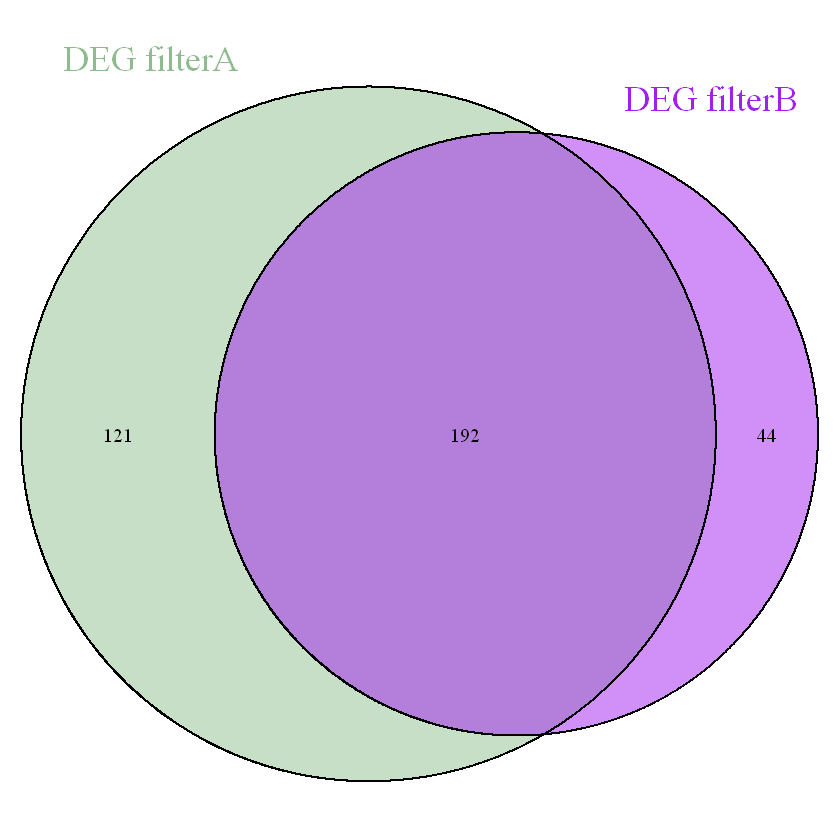

In [39]:
print(paste("Using filterA to filter out low expressed transcripts, ",length(pf0.01)," DEG are retrieved (adj pv < 0.01) ; using filterB ",length(res0.01$geneName),"  DEG are retrieved (adj pv < 0.01)", paste=""))
inter1 <- intersect(res0.01$geneName,pf0.01)
print(paste("These 2 DEG datasets have ",length(inter1)," DEG in common", sep=""))
print("Here are the names of genes present in DEG filterA dataset but not in DEG filterB dataset")      
setdiff(pf0.01,res0.01$geneName)
print("Here are the names of genes present in DEG filterB dataset but not in DEG filterA dataset")      
setdiff(res0.01$geneName,pf0.01)
draw.pairwise.venn(length(pf0.01),length(res0.01$geneName),length(inter1),category=c("DEG filterA","DEG filterB"),
                   fill=c("darkseagreen","purple"), cat.col=c("darkseagreen","purple"), cat.cex=1.8, cat.pos=c(-30,30), 
                   cat.dist=c(0.05,0.05), quiet=TRUE)


#### Using adj p-value <0.05 :

[1] "Using filterA to filter out low expressed transcripts,  810  DEG are retrieved (adj pv < 0.05) ; using filterB  678   DEG are retrieved (adj pv < 0.05) "
[1] "These 2 DEG datasets have 515 DEG in common"
[1] "Here are the names of genes present in DEG filterA dataset but not in DEG filterB dataset"


[1] "DLAgn_00000320" "DLAgn_00002340" "DLAgn_00002370" "DLAgn_00002530"
  [5] "DLAgn_00003100" "DLAgn_00003330" "DLAgn_00004910" "DLAgn_00005760"
  [9] "DLAgn_00007000" "DLAgn_00007010" "DLAgn_00009480" "DLAgn_00011110"
 [13] "DLAgn_00011260" "DLAgn_00011500" "DLAgn_00011970" "DLAgn_00013280"
 [17] "DLAgn_00013780" "DLAgn_00015500" "DLAgn_00016650" "DLAgn_00016940"
 [21] "DLAgn_00017300" "DLAgn_00019260" "DLAgn_00021000" "DLAgn_00022860"
 [25] "DLAgn_00025320" "DLAgn_00026470" "DLAgn_00027490" "DLAgn_00028130"
 [29] "DLAgn_00029200" "DLAgn_00030090" "DLAgn_00030470" "DLAgn_00030530"
 [33] "DLAgn_00030750" "DLAgn_00031970" "DLAgn_00033780" "DLAgn_00034040"
 [37] "DLAgn_00037130" "DLAgn_00037330" "DLAgn_00037580" "DLAgn_00038320"
 [41] "DLAgn_00038360" "DLAgn_00039260" "DLAgn_00039600" "DLAgn_00041380"
 [45] "DLAgn_00042160" "DLAgn_00042580" "DLAgn_00044140" "DLAgn_00044830"
 [49] "DLAgn_00045540" "DLAgn_00046450" "DLAgn_00047220" "DLAgn_00048350"
 [53] "DLAgn_00052290" "DLAgn_00053770" "DLAgn_00054390" "DLAgn_00054420"
 [57] "DLAgn_00054700" "DLAgn_00054800" "DLAgn_00055570" "DLAgn_00056090"
 [61] "DLAgn_00056120" "DLAgn_00057150" "DLAgn_00058010" "DLAgn_00059720"
 [65] "DLAgn_00059750" "DLAgn_00060940" "DLAgn_00062460" "DLAgn_00063160"
 [69] "DLAgn_00063670" "DLAgn_00063800" "DLAgn_00063870" "DLAgn_00064020"
 [73] "DLAgn_00065500" "DLAgn_00068250" "DLAgn_00071190" "DLAgn_00073190"
 [77] "DLAgn_00077440" "DLAgn_00077640" "DLAgn_00079830" "DLAgn_00081820"
 [81] "DLAgn_00083270" "DLAgn_00084830" "DLAgn_00086100" "DLAgn_00087500"
 [85] "DLAgn_00089530" "DLAgn_00089660" "DLAgn_00090790" "DLAgn_00090910"
 [89] "DLAgn_00091690" "DLAgn_00092370" "DLAgn_00092960" "DLAgn_00094290"
 [93] "DLAgn_00094460" "DLAgn_00095270" "DLAgn_00096540" "DLAgn_00096960"
 [97] "DLAgn_00097630" "DLAgn_00097750" "DLAgn_00098120" "DLAgn_00098810"
[101] "DLAgn_00102580" "DLAgn_00104690" "DLAgn_00104950" "DLAgn_00106240"
[105] "DLAgn_00110600" "DLAgn_00111100" "DLAgn_00112490" "DLAgn_00113310"
[109] "DLAgn_00113600" "DLAgn_00114540" "DLAgn_00114880" "DLAgn_00115080"
[113] "DLAgn_00116090" "DLAgn_00117030" "DLAgn_00117110" "DLAgn_00117150"
[117] "DLAgn_00117720" "DLAgn_00118290" "DLAgn_00118620" "DLAgn_00118710"
[121] "DLAgn_00118880" "DLAgn_00120960" "DLAgn_00122620" "DLAgn_00123740"
[125] "DLAgn_00123800" "DLAgn_00123860" "DLAgn_00123910" "DLAgn_00124430"
[129] "DLAgn_00126000" "DLAgn_00126590" "DLAgn_00126610" "DLAgn_00129090"
[133] "DLAgn_00131710" "DLAgn_00132440" "DLAgn_00132950" "DLAgn_00134330"
[137] "DLAgn_00135860" "DLAgn_00136290" "DLAgn_00137730" "DLAgn_00137880"
[141] "DLAgn_00139500" "DLAgn_00140400" "DLAgn_00140800" "DLAgn_00141890"
[145] "DLAgn_00142710" "DLAgn_00143850" "DLAgn_00144790" "DLAgn_00145430"
[149] "DLAgn_00146330" "DLAgn_00146440" "DLAgn_00146860" "DLAgn_00146990"
[153] "DLAgn_00148530" "DLAgn_00148940" "DLAgn_00149080" "DLAgn_00150880"
[157] "DLAgn_00151630" "DLAgn_00153190" "DLAgn_00154790" "DLAgn_00156190"
[161] "DLAgn_00156710" "DLAgn_00156780" "DLAgn_00157800" "DLAgn_00157930"
[165] "DLAgn_00158230" "DLAgn_00160170" "DLAgn_00161420" "DLAgn_00161480"
[169] "DLAgn_00163450" "DLAgn_00165630" "DLAgn_00165680" "DLAgn_00165880"
[173] "DLAgn_00166770" "DLAgn_00167380" "DLAgn_00168110" "DLAgn_00168480"
[177] "DLAgn_00169550" "DLAgn_00170600" "DLAgn_00170870" "DLAgn_00171450"
[181] "DLAgn_00172080" "DLAgn_00172960" "DLAgn_00173100" "DLAgn_00173160"
[185] "DLAgn_00175070" "DLAgn_00176130" "DLAgn_00177290" "DLAgn_00178250"
[189] "DLAgn_00179870" "DLAgn_00181660" "DLAgn_00181690" "DLAgn_00182800"
[193] "DLAgn_00183290" "DLAgn_00183330" "DLAgn_00183720" "DLAgn_00183730"
[197] "DLAgn_00185090" "DLAgn_00185550" "DLAgn_00185650" "DLAgn_00187480"
[201] "DLAgn_00187560" "DLAgn_00190120" "DLAgn_00190450" "DLAgn_00191100"
[205] "DLAgn_00194390" "DLAgn_00196210" "DLAgn_00197410" "DLAgn_00197720"
[209] "DLAgn_00198470" "DLAgn_00200130" "DLAgn_00201430" "DLAgn_00202620"
[213] "DLAgn_00206540" "DLAgn_00206690" "DLAgn_00207270" "DLAgn_00208020"
[217] 

[1] "Here are the names of genes present in DEG filterB dataset but not in DEG filterA dataset"


[1] "DLAgn_00000410" "DLAgn_00002540" "DLAgn_00003520" "DLAgn_00006980"
  [5] "DLAgn_00008180" "DLAgn_00008540" "DLAgn_00008670" "DLAgn_00009170"
  [9] "DLAgn_00009590" "DLAgn_00011210" "DLAgn_00011740" "DLAgn_00012150"
 [13] "DLAgn_00012160" "DLAgn_00013530" "DLAgn_00014320" "DLAgn_00014920"
 [17] "DLAgn_00015510" "DLAgn_00015800" "DLAgn_00016380" "DLAgn_00016880"
 [21] "DLAgn_00018180" "DLAgn_00019800" "DLAgn_00023000" "DLAgn_00023130"
 [25] "DLAgn_00023560" "DLAgn_00026510" "DLAgn_00026720" "DLAgn_00029420"
 [29] "DLAgn_00034010" "DLAgn_00034110" "DLAgn_00041230" "DLAgn_00041820"
 [33] "DLAgn_00044710" "DLAgn_00046490" "DLAgn_00047340" "DLAgn_00048060"
 [37] "DLAgn_00049540" "DLAgn_00054670" "DLAgn_00055890" "DLAgn_00057070"
 [41] "DLAgn_00061030" "DLAgn_00063230" "DLAgn_00065090" "DLAgn_00066440"
 [45] "DLAgn_00067180" "DLAgn_00069810" "DLAgn_00072500" "DLAgn_00078150"
 [49] "DLAgn_00078250" "DLAgn_00079530" "DLAgn_00079790" "DLAgn_00081090"
 [53] "DLAgn_00081140" "DLAgn_00081880" "DLAgn_00088230" "DLAgn_00090050"
 [57] "DLAgn_00094930" "DLAgn_00095180" "DLAgn_00095310" "DLAgn_00096770"
 [61] "DLAgn_00096860" "DLAgn_00118810" "DLAgn_00119180" "DLAgn_00119930"
 [65] "DLAgn_00119950" "DLAgn_00121120" "DLAgn_00125010" "DLAgn_00127090"
 [69] "DLAgn_00128820" "DLAgn_00129700" "DLAgn_00134140" "DLAgn_00134410"
 [73] "DLAgn_00134930" "DLAgn_00136840" "DLAgn_00138030" "DLAgn_00139970"
 [77] "DLAgn_00106140" "DLAgn_00110950" "DLAgn_00112590" "DLAgn_00112860"
 [81] "DLAgn_00113400" "DLAgn_00113550" "DLAgn_00114280" "DLAgn_00114380"
 [85] "DLAgn_00140640" "DLAgn_00141430" "DLAgn_00145690" "DLAgn_00149370"
 [89] "DLAgn_00151270" "DLAgn_00152810" "DLAgn_00155450" "DLAgn_00158550"
 [93] "DLAgn_00159310" "DLAgn_00160440" "DLAgn_00165030" "DLAgn_00165190"
 [97] "DLAgn_00166540" "DLAgn_00166600" "DLAgn_00167030" "DLAgn_00169470"
[101] "DLAgn_00172180" "DLAgn_00172620" "DLAgn_00173200" "DLAgn_00177480"
[105] "DLAgn_00183420" "DLAgn_00185450" "DLAgn_00187730" "DLAgn_00189900"
[109] "DLAgn_00190670" "DLAgn_00191680" "DLAgn_00193700" "DLAgn_00193720"
[113] "DLAgn_00193750" "DLAgn_00194650" "DLAgn_00196120" "DLAgn_00197960"
[117] "DLAgn_00198440" "DLAgn_00199040" "DLAgn_00199320" "DLAgn_00200080"
[121] "DLAgn_00200100" "DLAgn_00200410" "DLAgn_00200850" "DLAgn_00200940"
[125] "DLAgn_00201570" "DLAgn_00203000" "DLAgn_00204350" "DLAgn_00205170"
[129] "DLAgn_00205630" "DLAgn_00205670" "DLAgn_00206260" "DLAgn_00207910"
[133] "DLAgn_00208170" "DLAgn_00210480" "DLAgn_00211880" "DLAgn_00212190"
[137] "DLAgn_00212380" "DLAgn_00213850" "DLAgn_00218550" "DLAgn_00218830"
[141] "DLAgn_00219350" "DLAgn_00219530" "DLAgn_00224480" "DLAgn_00225960"
[145] "DLAgn_00230130" "DLAgn_00232180" "DLAgn_00235020" "DLAgn_00235160"
[149] "DLAgn_00236470" "DLAgn_00241900" "DLAgn_00244210" "DLAgn_00244350"
[153] "DLAgn_00244940" "DLAgn_00246240" "DLAgn_00247450" "DLAgn_00248480"
[157] "DLAgn_00249230" "DLAgn_00254100" "DLAgn_00255880" "DLAgn_00263430"
[161] "DLAgn_00264720" "DLAgn_00265610" "DLAgn_00266210"

(polygon[GRID.polygon.509], polygon[GRID.polygon.510], polygon[GRID.polygon.511], polygon[GRID.polygon.512], text[GRID.text.513], text[GRID.text.514], text[GRID.text.515], text[GRID.text.516], text[GRID.text.517]) 

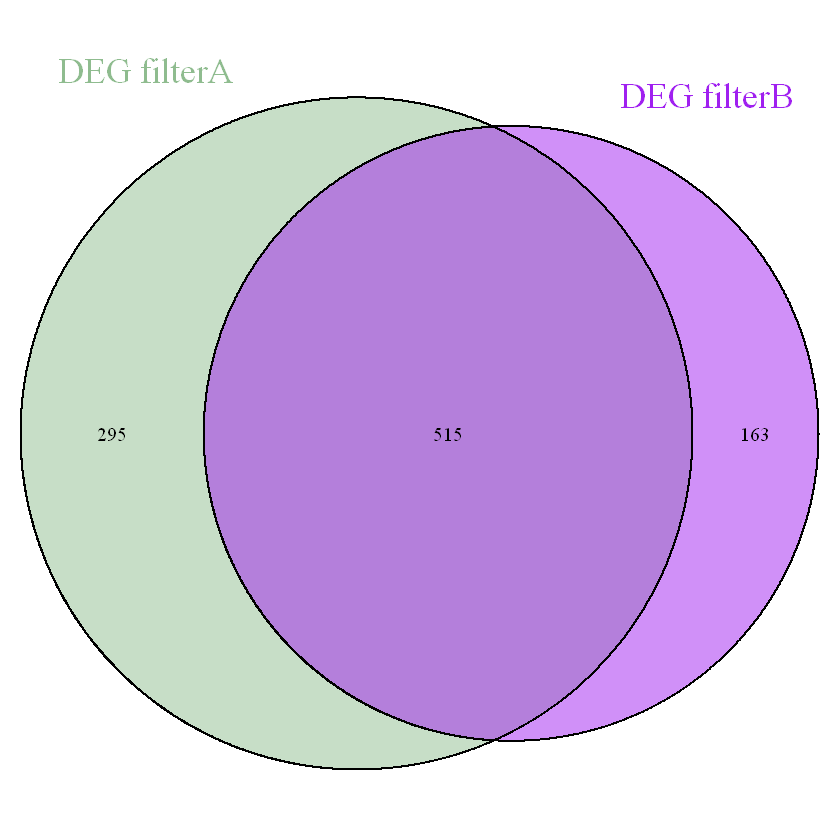

In [40]:
print(paste("Using filterA to filter out low expressed transcripts, ",length(pf0.05)," DEG are retrieved (adj pv < 0.05) ; using filterB ",length(res0.05$geneName),"  DEG are retrieved (adj pv < 0.05)", paste=""))
inter2 <- intersect(res0.05$geneName,pf0.05)
print(paste("These 2 DEG datasets have ",length(inter2)," DEG in common", sep=""))
print("Here are the names of genes present in DEG filterA dataset but not in DEG filterB dataset")      
setdiff(pf0.05,res0.05$geneName)
print("Here are the names of genes present in DEG filterB dataset but not in DEG filterA dataset")      
setdiff(res0.05$geneName,pf0.05)
draw.pairwise.venn(length(pf0.05),length(res0.05$geneName),length(inter2),category=c("DEG filterA","DEG filterB"),
                   fill=c("darkseagreen","purple"), cat.col=c("darkseagreen","purple"), cat.cex=1.8, cat.pos=c(-30,30), 
                   cat.dist=c(0.05,0.05), quiet=TRUE)

## Annotation

### Import annotation files

In [41]:
go <- read.table(go_file, h=F, sep="\t") ; head(go)
ann <- read.csv(ann_file, h=T, sep="\t") ; head(ann)

V1             V2        
1 DLAgn_00000010 GO:0001756
2 DLAgn_00000010 GO:0001839
3 DLAgn_00000010 GO:0001947
4 DLAgn_00000010 GO:0005615
5 DLAgn_00000010 GO:0005886
6 DLAgn_00000010 GO:0006508

Seq..Name      Seq..Description                                 Seq..Length
1 DLAgn_00215230 zinc finger hit domain-containing protein 1-like  483       
2 DLAgn_00210740 ras gtpase-activating protein ngap-like          2697       
3 DLAgn_00218000 tgf-beta receptor type-1-like                    1377       
4 DLAgn_00218150 t-cell receptor alpha                             498       
5 DLAgn_00218650 immunoglobulin light chain precursor              741       
6 DLAgn_00222140 lrr and pyd domains-containing protein 12-like   1569       
  X.Hits min..eValue  mean.Similarity X.GOs
1 20     3.20686E-23  59.5%            1   
2 20     0.0          90.15%           6   
3 20     0.0          80.55%          50   
4 20     1.8047E-56   60.1%            0   
5 20     1.86876E-108 81.75%           1   
6 20     0.0          76.0%            2   
  GOs                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1 F:protein binding                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Merge with differentially expressed genes
Resulting tables from DESeq2 differential analyses are merged with annotation files.
Theses annotation files result from comparative analyses with public databases using Blast.
The main annotation file is composed of 11 fields :
- **seqName** : gene name in genome fasta file
- **seqDescription** : 
- **seqLength** : gene length (bp)
- **nbHits** : Number oh hits
- **min_eValue** : minimum e-value
- **meanSimilarity** : mean sequence simimlarity (%)
- **nbGOs** : Number of associated Gene Ontology (GO) Terms
- **GOs** : GO
- **enzymeCodes** : enzyme code if existing
- **interProScan** : interproscan ID if existing
- **symbol** : gene symbol if existing

In [42]:
resa <- merge(res, ann, by.x="geneName", by.y="Seq..Name") 
colnames(resa) <- c('geneName','baseMean','log2FoldChange','lfcSE','pvalue','padj','seqDescription','seqLength','nbHits','min_eValue','meanSimilarity','nbGOs','GOs','enzymeCodes','interProScan','symbol')
print("First line of results table")
resa[1,]

res0.01a <- merge(res0.01, ann, by.x="geneName", by.y="Seq..Name") 
colnames(res0.01a) <- c('geneName','baseMean','log2FoldChange','lfcSE','pvalue','padj','seqDescription','seqLength','nbHits','min_eValue','meanSimilarity','nbGOs','GOs','enzymeCodes','interProScan','symbol')

res0.05a <- merge(res0.05, ann, by.x="geneName", by.y="Seq..Name"); 
colnames(res0.05a) <- c('geneName','baseMean','log2FoldChange','lfcSE','pvalue','padj','seqDescription','seqLength','nbHits','min_eValue','meanSimilarity','nbGOs','GOs','enzymeCodes','interProScan','symbol')

res0.01_1.5a <- merge(res0.01_1.5, ann, by.x="geneName", by.y="Seq..Name") 
colnames(res0.01_1.5a) <- c('geneName','baseMean','log2FoldChange','lfcSE','pvalue','padj','seqDescription','seqLength','nbHits','min_eValue','meanSimilarity','nbGOs','GOs','enzymeCodes','interProScan','symbol')

res0.05_1.5a <- merge(res0.05_1.5, ann, by.x="geneName", by.y="Seq..Name") 
colnames(res0.05_1.5a) <- c('geneName','baseMean','log2FoldChange','lfcSE','pvalue','padj','seqDescription','seqLength','nbHits','min_eValue','meanSimilarity','nbGOs','GOs','enzymeCodes','interProScan','symbol')

[1] "First line of results table"


geneName       baseMean log2FoldChange lfcSE     pvalue    padj     
1 DLAgn_00000030 18.20529 0.02420895     0.1153545 0.5432918 0.7733377
  seqDescription     seqLength nbHits min_eValue  meanSimilarity nbGOs
1 tissue factor-like 870       20     1.56681E-86 59.2%          3    
  GOs                                                            enzymeCodes
1 P:blood coagulation; C:integral to membrane; F:protein binding -          
  interProScan                                                                                                                                                                                                       
1 IPR001187 (PRINTS); IPR003961 (SUPERFAMILY); IPR013783 (G3DSA:2.60.40.GENE3D); IPR015373 (PFAM); PTHR20859 (PANTHER), PTHR20859:SF22 (PANTHER), PF01108 (PFAM), seg (SEG), SignalP-NN(euk) (SIGNALP), tmhmm (TMHMM)
  symbol
1 F3A

In [43]:
# Function to get list of GOs from GO file
getGOlist <- function(dt,go) {
    for(i in 1:dim(dt)[1]) {
        dt[i,"GO_list"] <- paste(as.vector(go[which(go$V1==dt[i,"geneName"]),]$V2), collapse = ';')
    }
    return(dt)
}
 
# Add information to result data tables
resag <- getGOlist(resa, go)
res0.01ag <- getGOlist(res0.01a, go)
res0.05ag <- getGOlist(res0.05a, go)
res0.01_1.5ag <- getGOlist(res0.01_1.5a, go)
res0.05_1.5ag <- getGOlist(res0.05_1.5a, go)

In [44]:
allGenes <- as.vector(res$padj)
names(allGenes) <- res$geneName
geneIDs = res0.01ag[c(1,17)]
geneIDs
sampleGOdata <- new("topGOdata", description = "Simple session", 
                    ontology = "BP", allGenes = allGenes, geneSel = geneIDs,
                    nodeSize = 10, annot = annFUN.db, affyLib = affyLib)

inUniverse = geneIDs %in% c(anSig$ensembl_gene_id,  backG)
inSelection =  geneIDs %in% anSig$ensembl_gene_id

geneName      
1   DLAgn_00002450
2   DLAgn_00005800
3   DLAgn_00005900
4   DLAgn_00006020
5   DLAgn_00006750
6   DLAgn_00006910
7   DLAgn_00007790
8   DLAgn_00007910
9   DLAgn_00008540
10  DLAgn_00009470
11  DLAgn_00010730
12  DLAgn_00011900
13  DLAgn_00012020
14  DLAgn_00012160
15  DLAgn_00012210
16  DLAgn_00012950
17  DLAgn_00013930
18  DLAgn_00015250
19  DLAgn_00015510
20  DLAgn_00015680
21  DLAgn_00015800
22  DLAgn_00016810
23  DLAgn_00018160
24  DLAgn_00024200
25  DLAgn_00026690
26  DLAgn_00027050
27  DLAgn_00027120
28  DLAgn_00029420
29  DLAgn_00031450
30  DLAgn_00031730
<U+22EE>   <U+22EE>      
207 DLAgn_00223020
208 DLAgn_00223080
209 DLAgn_00228920
210 DLAgn_00229130
211 DLAgn_00231370
212 DLAgn_00232010
213 DLAgn_00233840
214 DLAgn_00236660
215 DLAgn_00237140
216 DLAgn_00237300
217 DLAgn_00239470
218 DLAgn_00239500
219 DLAgn_00242810
220 DLAgn_00246100
221 DLAgn_00247450
222 DLAgn_00247660
223 DLAgn_00251050
224 DLAgn_00252250
225 DLAgn_00253960
226 DLAgn_00255880
227 DLAgn_00257390
228 DLAgn_00257660
229 DLAgn_00259550
230 DLAgn_00261510
231 DLAgn_00262000
232 DLAgn_00262220
233 DLAgn_00264720
234 DLAgn_00265290
235 DLAgn_00266210
236 DLAgn_00266860
    GO_list                                                                                                                                                                                                                               
1   GO:0005975;GO:0016301;GO:0016310;GO:0016773                                                                                                                                                                                           
2   GO:0016020;GO:0055085                                                                                                                                                                                                                 
3   GO:0000287;GO:0004422;GO:0005829;GO:0006166;GO:0006168;GO:0006178;GO:0032263;GO:0032264;GO:0042803;GO:0046100;GO:0052657                                                                                                              
4   GO:0005606;GO:0005610;GO:0030155;GO:0030334;GO:0045995                                                                                                                                                                                
5   GO:0005524;GO:0005730;GO:0005743;GO:0055085                                                                                                                                                                                           
6   GO:0002062;GO:0002076;GO:0004991;GO:0005622;GO:0006874;GO:0017046;GO:0030282;GO:0043621;GO:0045453;GO:0048469                                                                                                                         
7   GO:0000166;GO:0001669;GO:0005634;GO:0007283;GO:0046332;GO:0048523;GO:0050772                                                                                                                                                          
8   GO:0003777;GO:0005524;GO:0005858;GO:0005874;GO:0007018;GO:0016887                                                                                                                                                                     
9   GO:0003674;GO:0005575;GO:0008150                                                                                                                                                                                                      
10  GO:0005515;GO:0005622;GO:0008270                                                                                                                                                                                                      
11  GO:0001553;GO:0001570;GO:0001822;GO:0005783;GO:0006672;GO:0006915;GO:0007283;GO:0008209;GO:0008210;GO:0009791;GO:0010761;GO:0016831;GO:0019752;GO:0030097;GO:0030170;GO:0033327;GO:0040014;GO:0048008;GO:0048705;GO:0060325           

ERROR: Error in getClass(Class, where = topenv(parent.frame())): "topGOdata" is not a defined class


In [ ]:
resag[c(1,2),]

## Tables and figures export 

### Figures (png format)

In [45]:
png(paste(working_dir,"/images/boxplot_raw-counts.png", sep=""))
boxplot(log(counts(ddsHTSeq),2), col=sample_color, las=2, main="Distribution of raw counts accross samples (log2)\nblue samples are control samples", warning=F)
dev.off()

png(paste(working_dir,"/images/barplot_total-counts.png", sep=""))
barplot(colSums(counts(ddsHTSeq)), col=sample_color, las=2, ylim=c(0,80000000), main="Total number of raw counts per sample\nblue samples are control samples")
dev.off()

png(paste(working_dir,"/images/barplot_null-counts.png", sep=""))
barplot(colSums(counts(ddsHTSeq)<5), col=sample_color, las=2, ylim=c(0,6000), main="Number of transcripts associated with\n less than 5 read counts")
dev.off()


png(paste(working_dir,"/images/densityplot_raw-all.png", sep=""))
dp_raw_all
dev.off()

png(paste(working_dir,"/images/densityplot_norm-all.png", sep=""))
dp_norm_all
dev.off()

png(paste(working_dir,"/images/densityplot_norm-DE0.01.png", sep=""))
dp_norm_DE0.01
dev.off()

png(paste(working_dir,"/images/densityplot_raw-DE0.01.png", sep=""))
dp_raw_DE0.01
dev.off()


png(paste(working_dir,"/images/pca_pc1_pc2.png", sep=""))
pca1
dev.off()

png(paste(working_dir,"/images/pca_pc1_pc3.png", sep=""))
pca2
dev.off()

png(paste(working_dir,"/images/clustering_samples.png", sep=""))
myplclust(hh, labels=rownames(df), lab.col=colo)
dev.off()

png(paste(working_dir,"/images/heatmap_samples.png", sep=""))
heatmap.2(mat, Rowv=as.dendrogram(hc),
          symm=TRUE, trace='none',
          col=rev(hmcol),margin=c(10, 10), colRow=colo, colCol=colo)
dev.off()

log2.norm.counts <- assay(nt)[select,]
pheatmap(log2.norm.counts,
         clustering_distance_cols = dist1, 
         clustering_method = "ward.D", 
         cluster_rows=FALSE,
         cluster_cols=TRUE, 
         annotation_col=df,
         show_rownames=TRUE,
         fontsize_row=5,
         fontsize_col=10,
         fontsize=8,
         annotation_colors = ann_colors, 
         main=paste("Clustered heatmap of 100 most abundant genes\n",dist1," distance with ",clust, " clustering method",sep=""),
         las=1,
         filename=paste(working_dir,"/images/heatmap_expression.png", sep=""))

png(paste(working_dir,"/images/dispersion_estimates.png", sep=""))
plotDispEsts(dds)
dev.off()

png(paste(working_dir,"/images/MA-plot_without-lfc-shrinkage.png", sep=""))
plotMA.DESeqResults(res_raw, main="Acidity vs. Control\nbefore lfc shrinkage", ylim=c(-10,10),alpha=0.05)
dev.off()

png(paste(working_dir,"/images/MA-plot_with-lfc-shrinkage.png", sep=""))
plotMA.DESeqResults(res, main="Acidity vs. Control\after apeglm shrinkage", ylim=c(-10,10),alpha=0.05)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

pdf 
  3

[1] 681   3


pdf 
  3

[1] 678   3


pdf 
  3

### Data tables (tab-separated txt format)

In [46]:
write.table(resag, paste(working_dir,"/all_genes.txt", sep=""), quote=F, row.names=F, sep="\t")
write.table(res0.01ag, paste(working_dir,"/DE-genes_acid-vs-control_pv0.01.txt", sep=""), quote=F, row.names=F, sep="\t")
write.table(res0.05ag, paste(working_dir,"/DE-genes_acid-vs-control_pv0.05.txt", sep=""), quote=F, row.names=F, sep="\t")
write.table(res0.01_1.5ag, paste(working_dir,"/DE-genes_acid-vs-control_pv0.01_fc1.5.txt", sep=""), quote=F, row.names=F, sep="\t")
write.table(res0.05_1.5ag, paste(working_dir,"/DE-genes_acid-vs-control_pv0.05_fc1.5.txt", sep=""), quote=F, row.names=F, sep="\t")

In [50]:
getwd()
write.table(log2.norm.counts.to.export, paste(working_dir,"/norm-counts-matrix_design2b.txt", sep=""), quote=F, row.names=T, sep="\t")


[1] "C:/Users/pauffret/Desktop/projets/LIVACID/results/R"

## Materials and methods for bioinformatic analyses

Read quality was assessed with fastqc v0.11.9 [1] and multiQC v1.9 [2].  
Raw reads were processed using Trim Galore v0.6.7 [3] to perform quality trimming (Q=15) and to remove the T overhang at 5' end of reads, according to Illumina recommendations for Stranded mRNA Prep protocol [4].  
Trimmed reads reads were mapped on *Dicentrarchus labrax* genome [5] using STAR v2.7.9a [6] with standard parameters. STAR outputs matrices of raw counts which were used to perform diffential analysis.  
To minimize the false-positive rate, the count matrices were filtered for low expressed transcripts (minimum counts=10). Differentially expressed genes (DEGs) between acidic and control samples were identified using DESeq2 v2.1.34 [7] and a collection of raphics and statistics packages [8-12] with R v4.1.2 (https://www.R-project.org/). DESeq2 method internally corrects for library size and uses negative binomial generalized linear models to test for differential expression. In this study the statistical model was built using 'counts ~ group' design formula, where group qualitative variable indicates sample group (acidity/control). Fold changes were adjusted using bayesian shrinkage estimators for effect sizes with apeglm package [13]. All features with absolute log2 fold change greater than 1.5 and adjusted p-value smaller than 0.05 (Benjamini-Hochberg method) were reported as differentially expressed (DEGs).

#### Summary of computing environment :

In [49]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19045)

Matrix products: default

locale:
[1] LC_COLLATE=French_France.1252  LC_CTYPE=French_France.1252   
[3] LC_MONETARY=French_France.1252 LC_NUMERIC=C                  
[5] LC_TIME=French_France.1252    

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] VennDiagram_1.7.1           futile.logger_1.4.3        
 [3] scales_1.1.1                apeglm_1.16.0              
 [5] gplots_3.1.1                RColorBrewer_1.1-2         
 [7] rafalib_1.0.0               gridExtra_2.3              
 [9] pheatmap_1.0.12             ggplot2_3.3.5              
[11] DESeq2_1.34.0               SummarizedExperiment_1.24.0
[13] Biobase_2.54.0              MatrixGenerics_1.6.0       
[15] matrixStats_0.61.0          GenomicRanges_1.46.1       
[17] GenomeInfoDb_1.30.1         IRanges_2.28.

## References 

- [1] Simon Andrews. Babraham bioinformatics - fastqc : A quality control tool
for high throughput sequence data. https://www.bioinformatics.babraham.ac.uk/projects/fastqc/
- [2] Philip Ewels, Mns Magnusson, Sverker Lundin, and Max Kller. Multiqc:
Summarize analysis results for multiple tools and samples in a single report.
Bioinformatics, 32:3047–3048, 10 2016.
- [3] Felix Krueger. Babraham bioinformatics - trim galore! https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/
- [4] Illumina. Best practices for read trimming for illumina stranded mrna and
total rna workflows, 2020.
- [5] Mbaye Tine, Heiner Kuhl, Pierre Alexandre Gagnaire, Bruno Louro, Er-
ick Desmarais, Rute S.T. Martins, Jochen Hecht, Florian Knaust, Khalid
Belkhir, Sven Klages, Roland Dieterich, Kurt Stueber, Francesc Pifer-
rer, Bruno Guinand, Nicolas Bierne, Filip A.M. Volckaert, Luca Bargel-
loni, Deborah M. Power, Francois Bonhomme, Adelino V.M. Canario, and
Richard Reinhardt. European sea bass genome and its variation provide
insights into adaptation to euryhalinity and speciation. Nature communi-
cations, 5:5770, 2014.
- [6] Alexander Dobin, Carrie A. Davis, Felix Schlesinger, Jorg Drenkow, Chris
Zaleski, Sonali Jha, Philippe Batut, Mark Chaisson, and Thomas R. Gin-
geras. Star: Ultrafast universal rna-seq aligner. Bioinformatics, 29:15–21,
1 2013.
- [7] Michael I. Love, Wolfgang Huber, and Simon Anders. Moderated estima-
tion of fold change and dispersion for rna-seq data with deseq2. Genome
Biology, 15, 12 2014.
- [8] Rafael A. Irizarry and Michael I. Love. rafalib: Convenience functions for
routine data exploration, 2015.
- [9] Raivo Kolde. pheatmap: Pretty heatmaps, 2019.
- [10] Hugo Varet, Loraine Brillet-Guguen, Jean Yves Coppe, and Marie Agns
Dillies. Sartools: A deseq2- and edger-based r pipeline for comprehensive
differential analysis of rna-seq data. PLoS ONE, 11, 6 2016.
- [11] Gregory R. Warnes, Ben Bolker, Lodewijk Bonebakker, Robert Gentleman,
Wolfgang Huber, Andy Liaw, Thomas Lumley, Martin Maechler, Arni Mag-
nusson, Steffen Moeller, Marc Schwartz, and Bill Venables. gplots: Various
r programming tools for plotting data, 2020.
- [12] Hadley Wickham. ggplot2: Elegant Graphics for Data Analysis. Springer-
Verlag New York, 2016.
- [13] Anqi Zhu, Joseph G. Ibrahim, and Michael I. Love. Heavy-tailed prior
distributions for sequence count data: Removing the noise and preserving
large differences. Bioinformatics, 35:2084–2092, 6 2019

## Data availability
Bioinformatics pipeline is available on [IFREMER Gitlab](https://gitlab.ifremer.fr/pa7b086/livacid) (internal access).